# MODULE

In [1]:
import os
import random

In [2]:
from squiggle_detector import *
from collections import OrderedDict

/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Get files from these species:

430699
425393
418330
417981
413329
397775
391448
391443
390602
389243
387128
370506
362754
362612
360973
360972
360971
360970
344283
330659
313426
302917
296661
225524
225523
197308
197307
197306
197305
197303
197302
177120
175780
173822
173821
166111
149514
145838
145837
145836
140975
109900
102889
102888
102887
102886
102885
70307
45033
35951
33616
20493
18382
18381
16875
15178
15177
15175


In [14]:
import json

with open('/Volumes/seagate3/xeno-canto/20181207/bonasa-umbellus/20181207-bonasa-umbellus.json') as json_file:  
    data = json.load(json_file)
    for p in data['recordings']:
        if p['q'] == 'A':
            print(p['id'])

433034
419823
416168


In [20]:
a_quality

['433034', '419823', '416168']

In [22]:
random.seed(123)
    
base_path = '/Volumes/seagate3/xeno-canto/20181207/'
species_dirs = ['bonasa-umbellus', 'meleagris-gallopavo', 'melanerpes-carolinus', 'parkesia-motacilla','haemorhous-purpureus']
recordings_to_use = []
for species_dir in species_dirs:
    species_json = os.path.join(base_path, species_dir, f'20181207-{species_dir}.json')
    with open(f'/Volumes/seagate3/xeno-canto/20181207/{species_dir}/20181207-{species_dir}.json') as json_file:  
        data = json.load(json_file)
        a_quality = []
        for p in data['recordings']:
            if p['q'] == 'A':
                a_quality.append(p['id'])
    
    choice = random.choice(a_quality)
    species_path = os.path.join(base_path, species_dir, 'mp3s')
    recordings_to_use.append(os.path.join(species_path, f'{choice}.mp3'))
    
recordings_to_use

['/Volumes/seagate3/xeno-canto/20181207/bonasa-umbellus/mp3s/433034.mp3',
 '/Volumes/seagate3/xeno-canto/20181207/meleagris-gallopavo/mp3s/136045.mp3',
 '/Volumes/seagate3/xeno-canto/20181207/melanerpes-carolinus/mp3s/397775.mp3',
 '/Volumes/seagate3/xeno-canto/20181207/parkesia-motacilla/mp3s/59130.mp3',
 '/Volumes/seagate3/xeno-canto/20181207/haemorhous-purpureus/mp3s/227880.mp3']

# Method with two rounds of detection

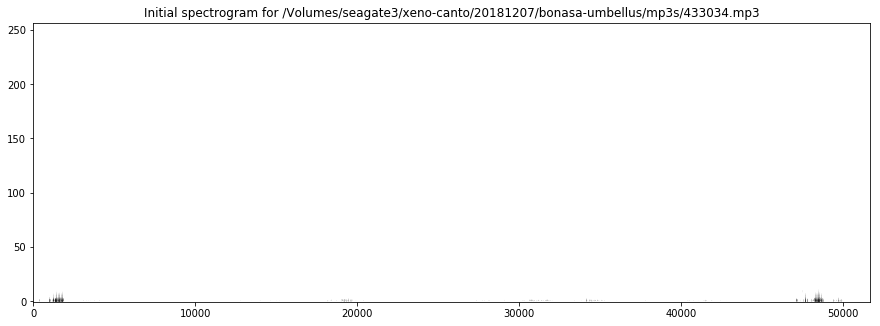

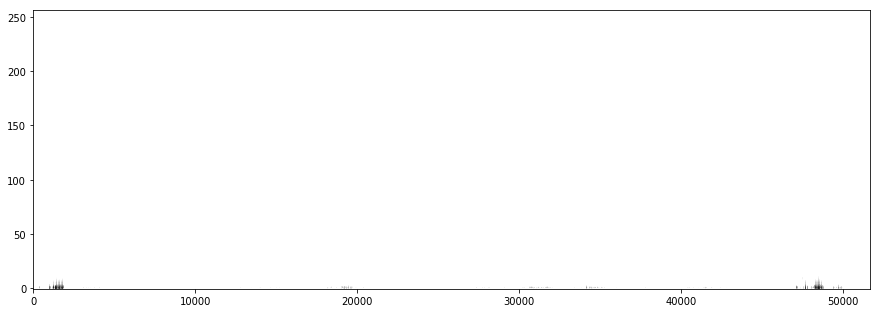

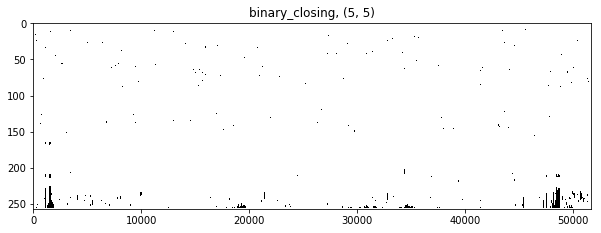

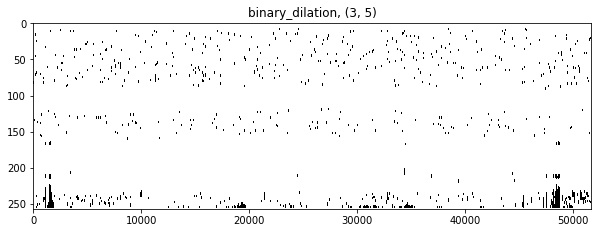

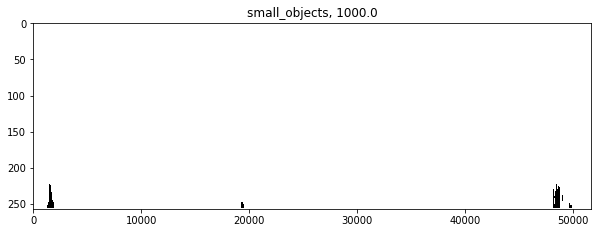

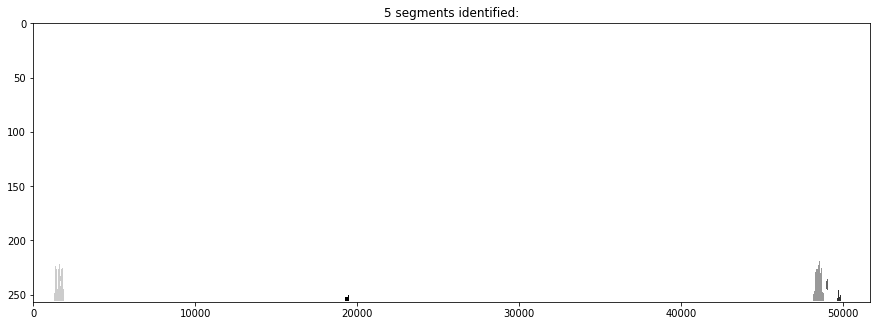

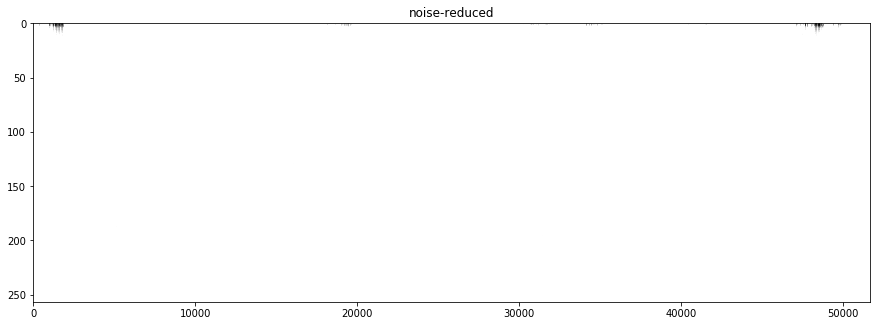

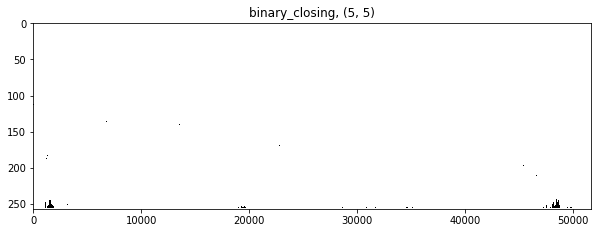

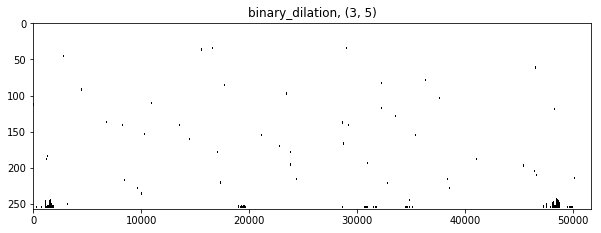

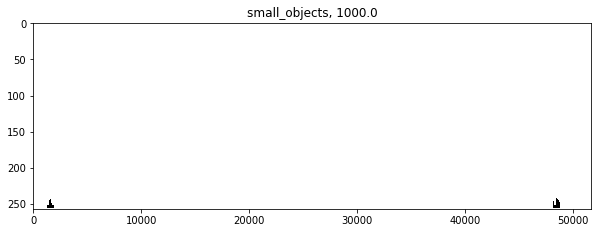

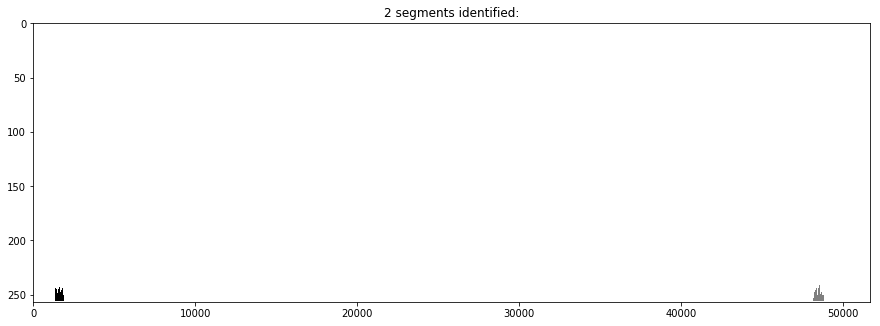

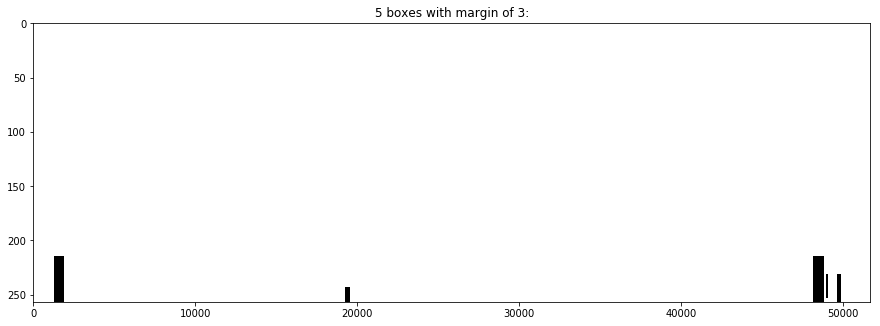

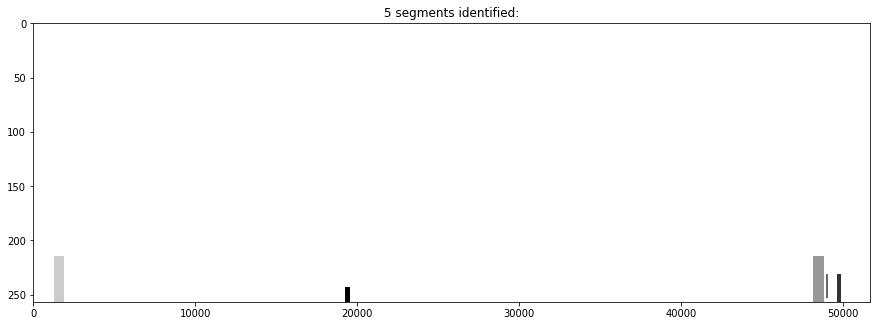

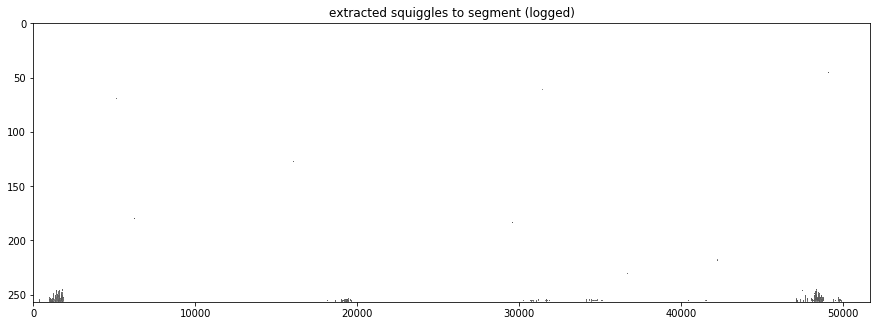

/Users/ter38/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


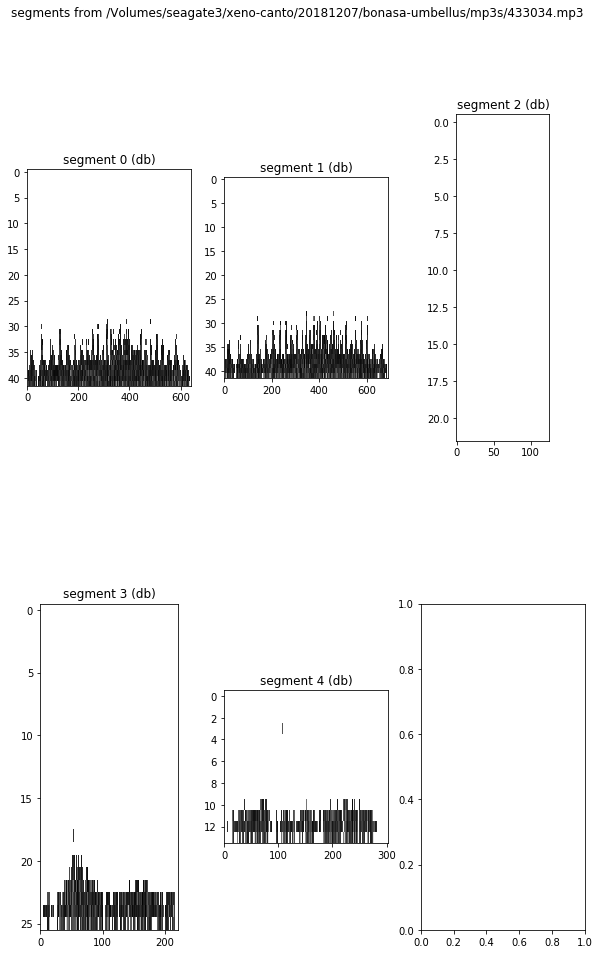

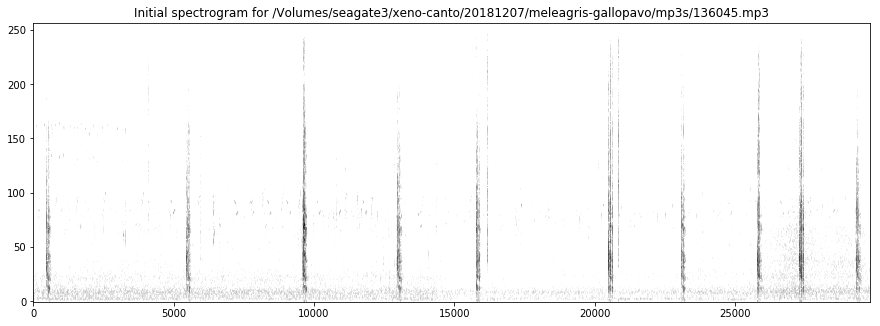

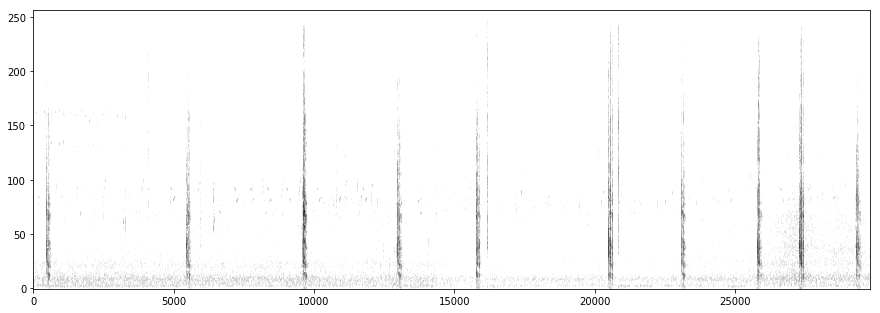

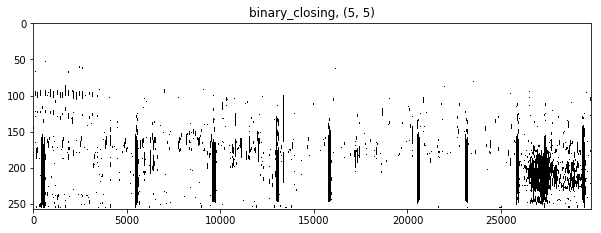

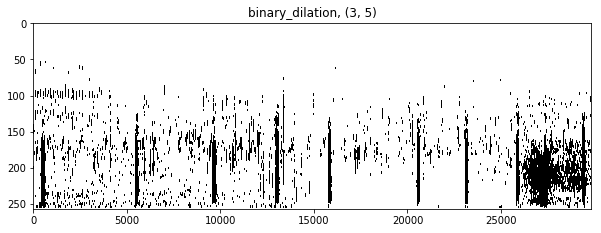

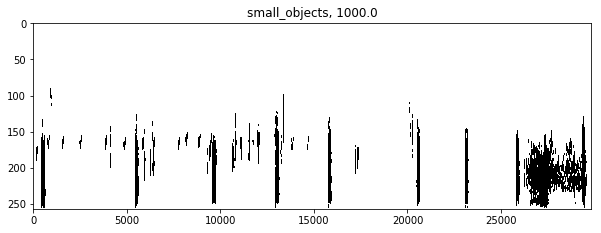

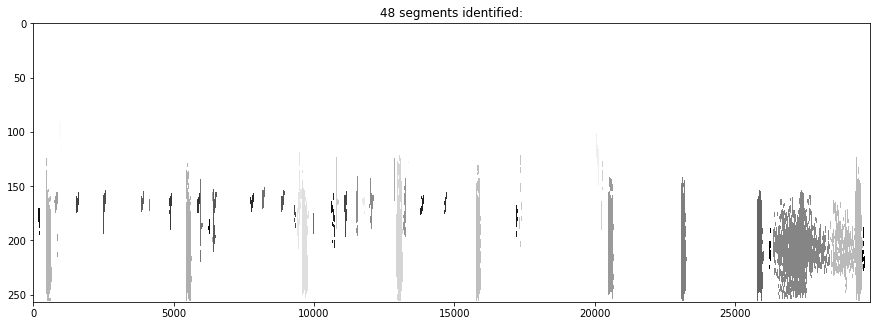

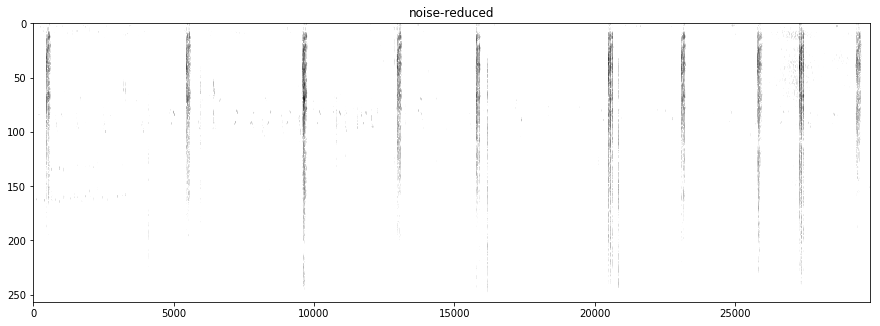

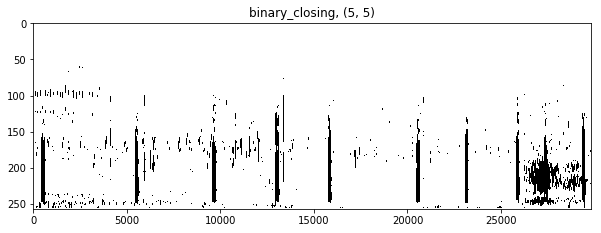

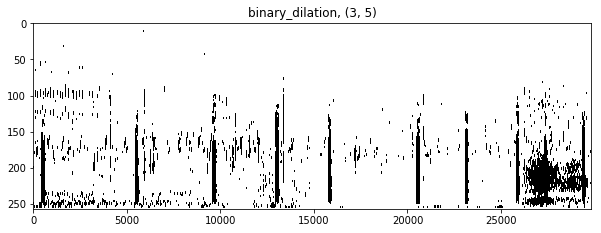

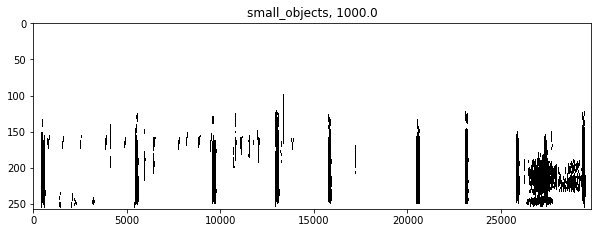

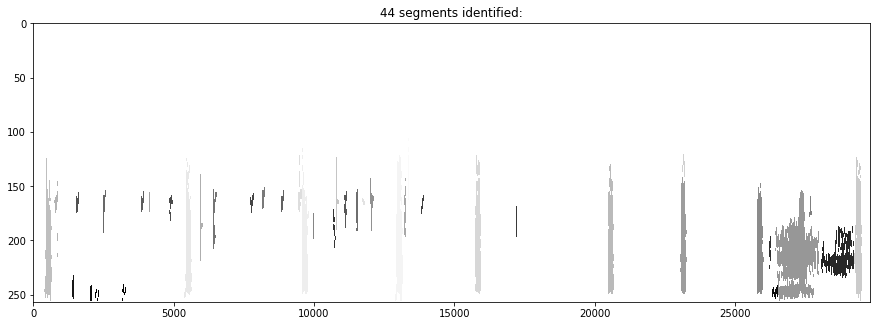

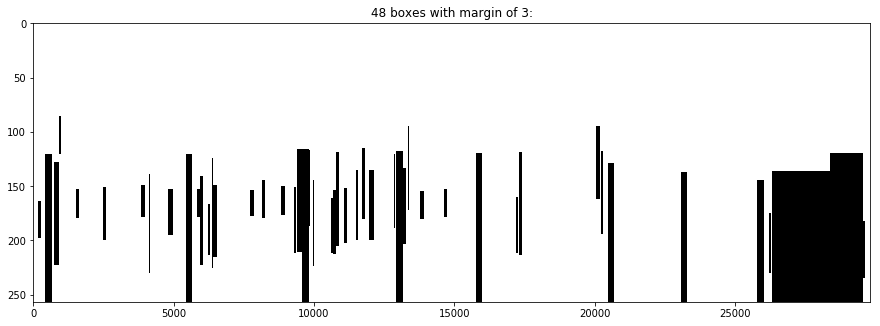

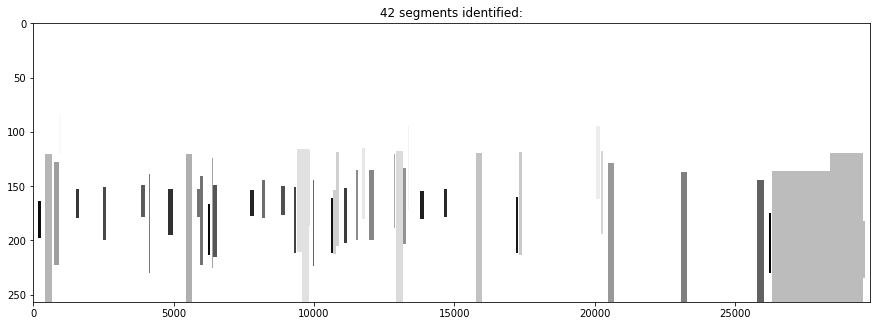

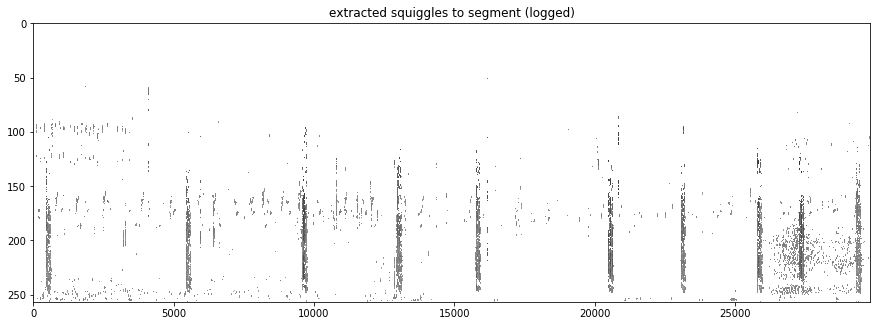

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning: divide by zero encountered in log


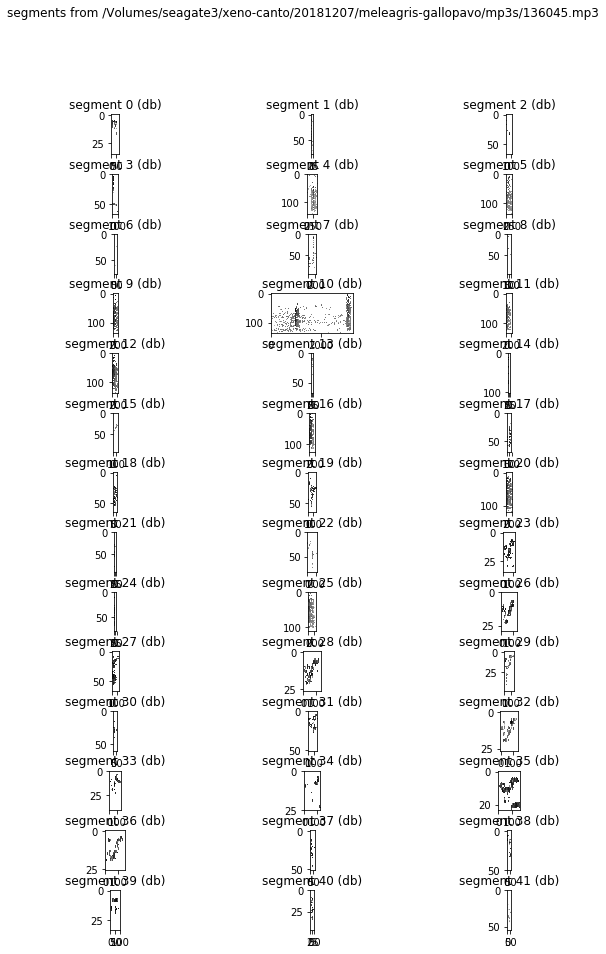

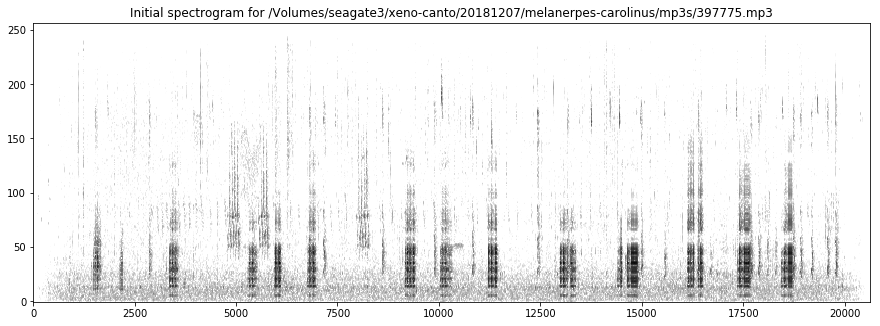

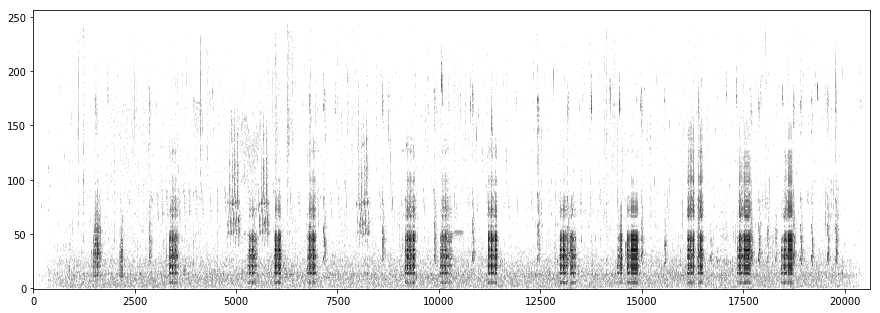

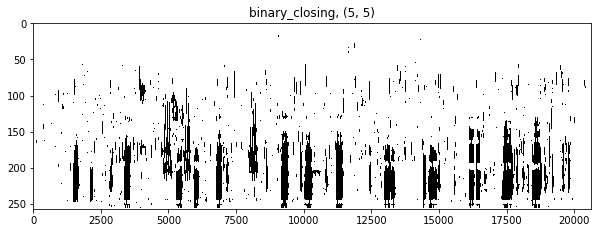

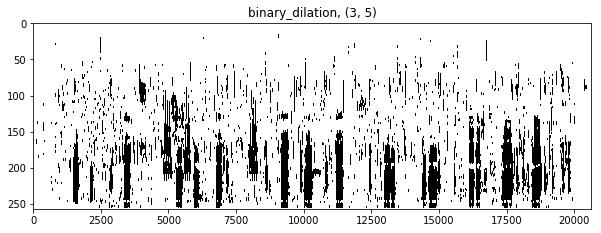

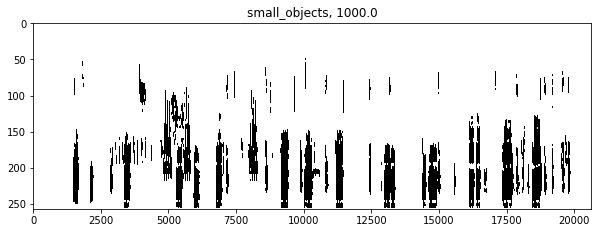

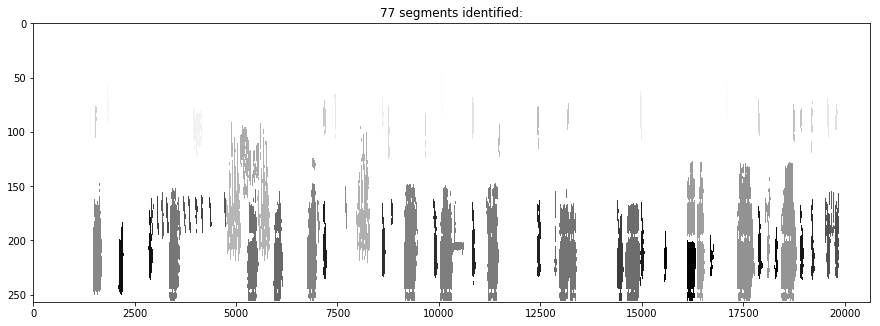

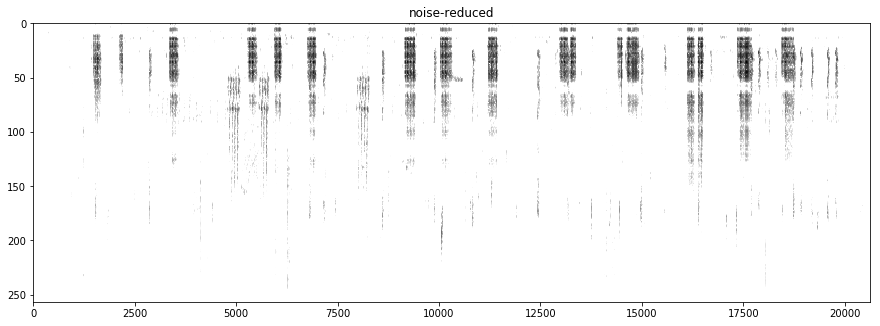

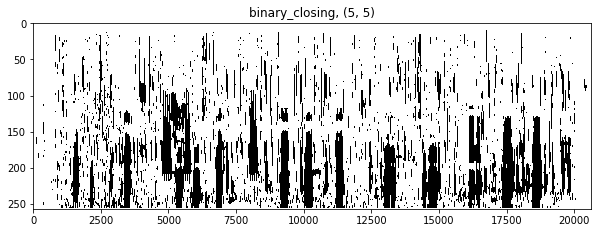

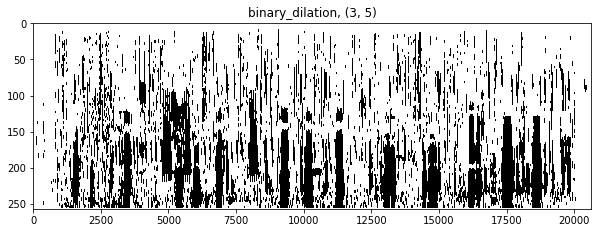

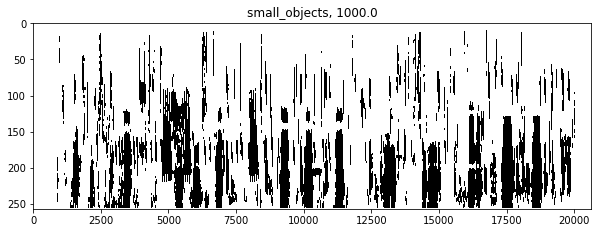

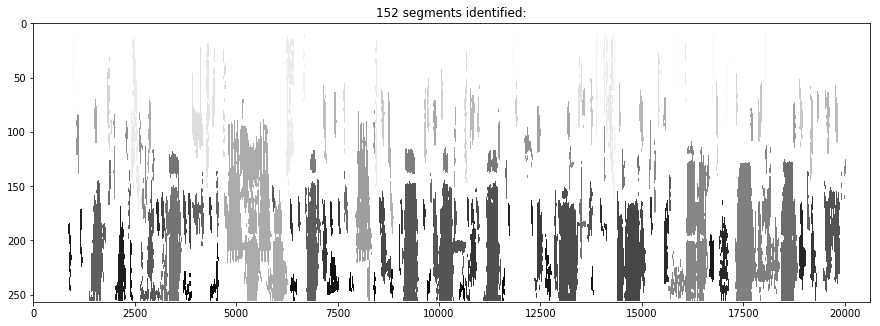

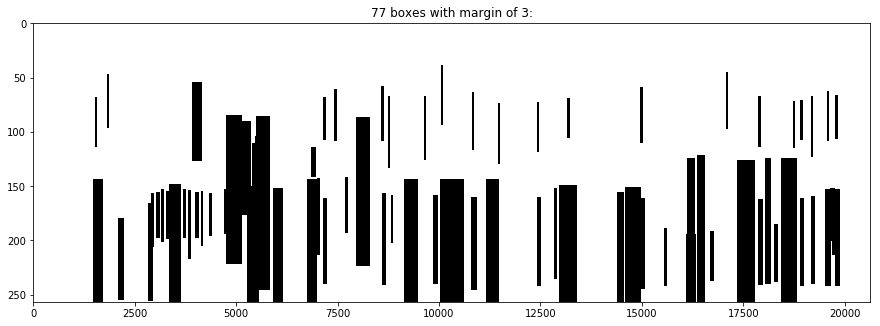

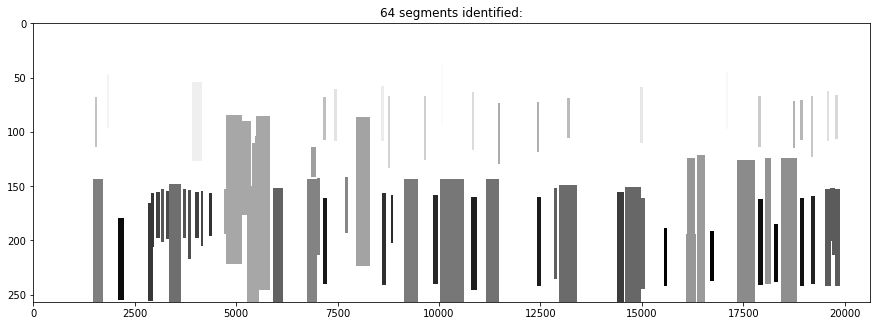

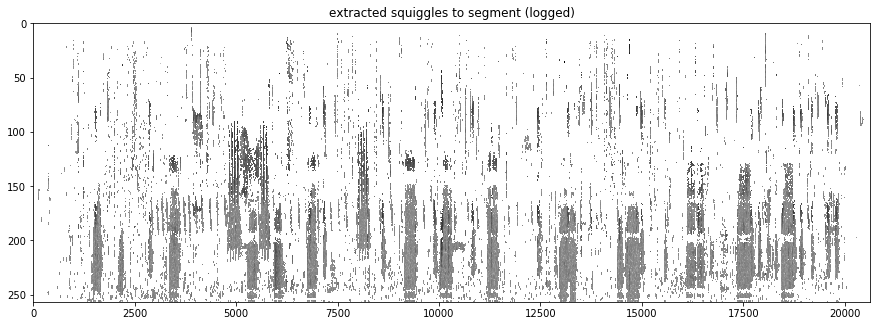

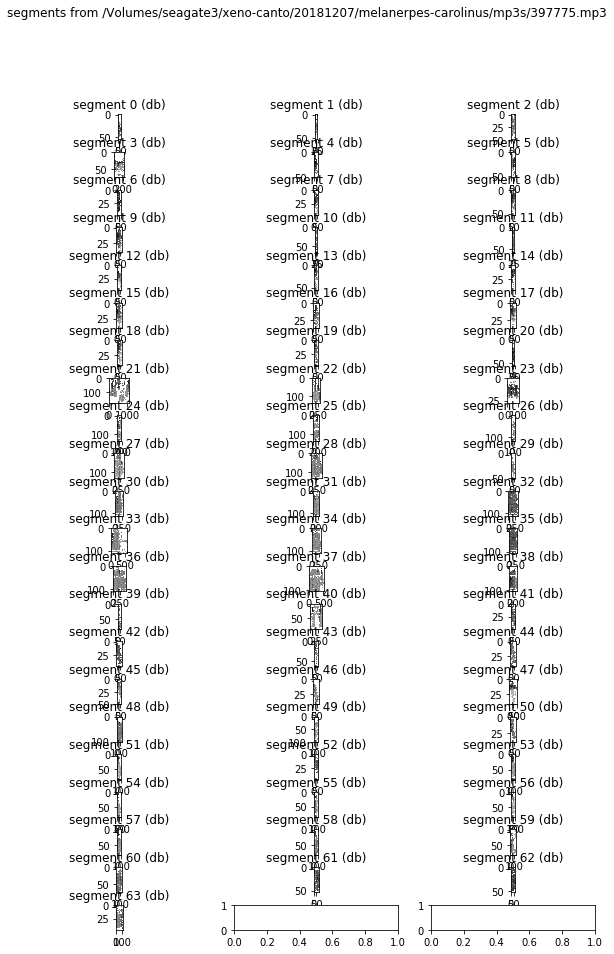

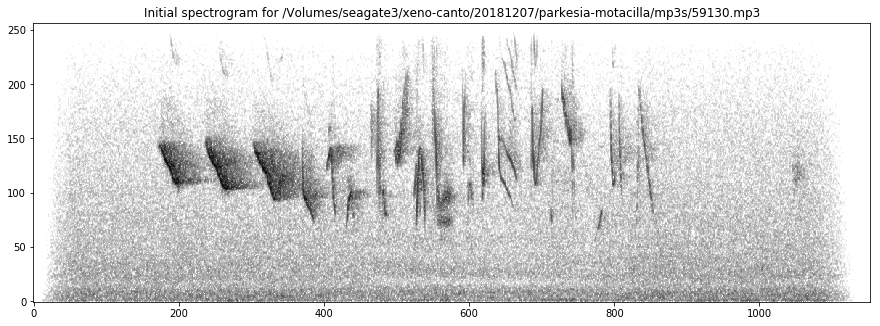

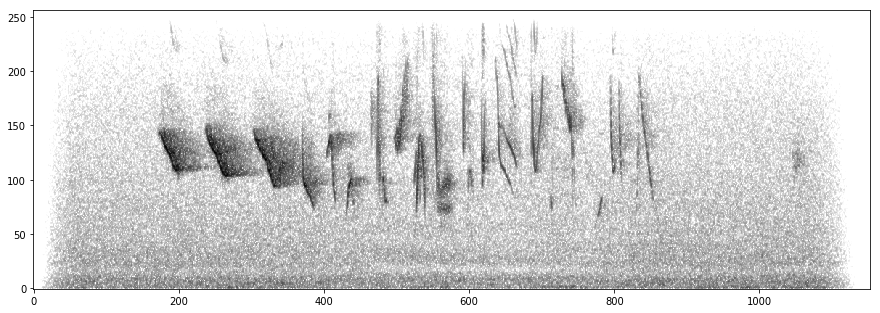

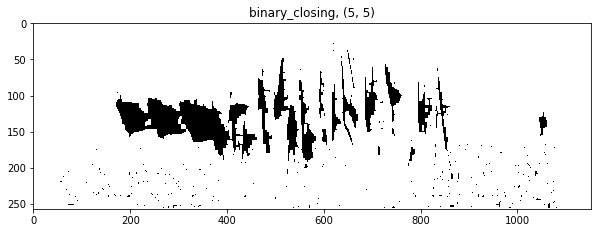

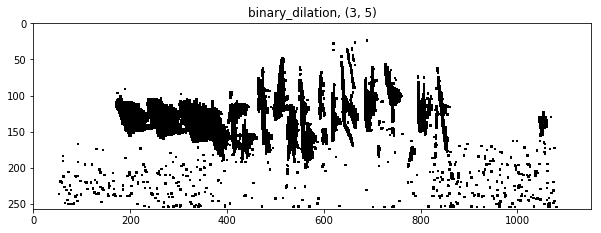

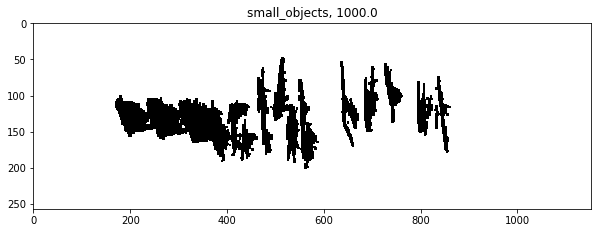

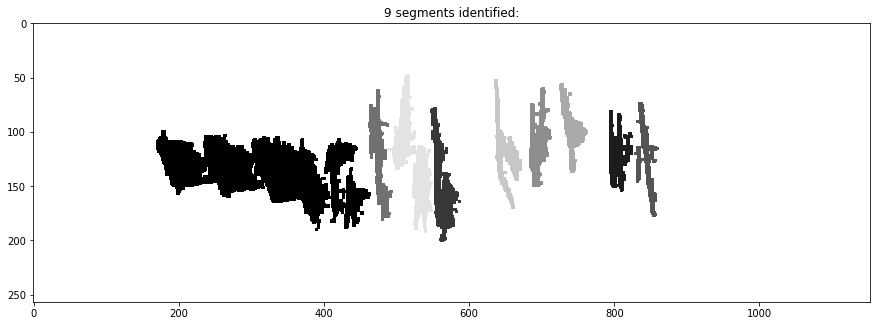

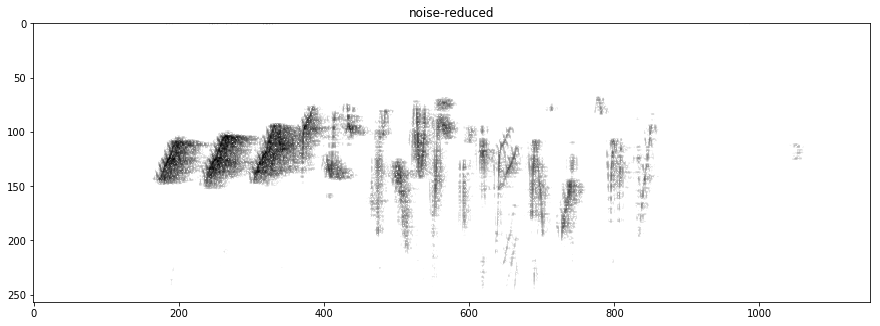

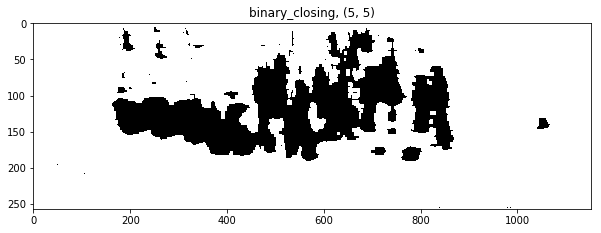

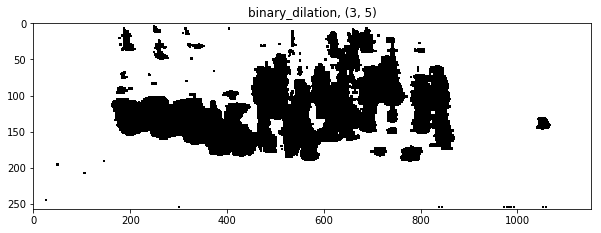

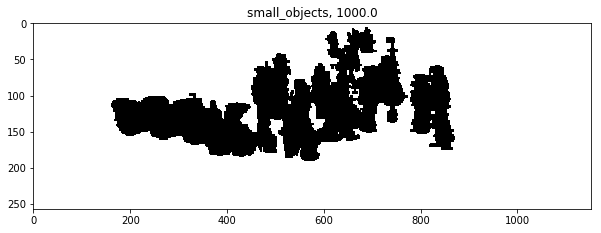

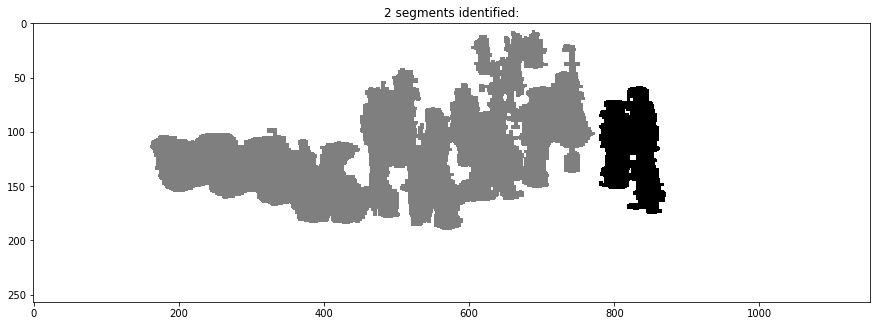

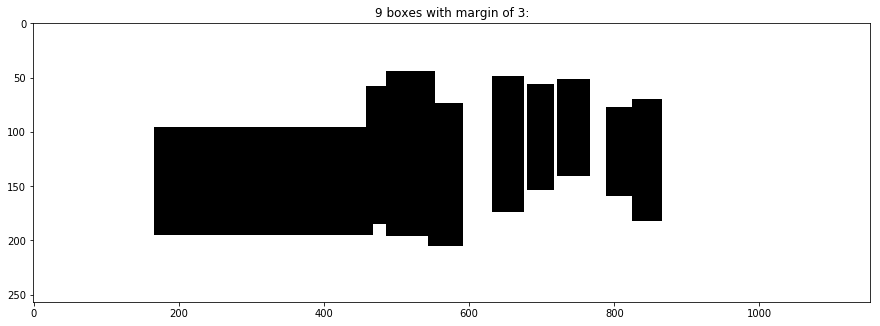

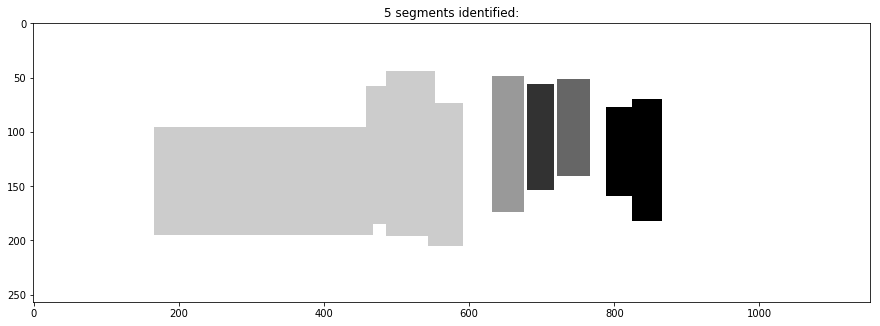

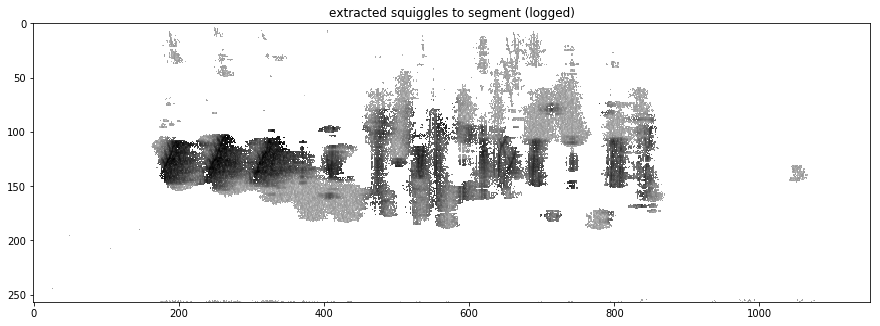

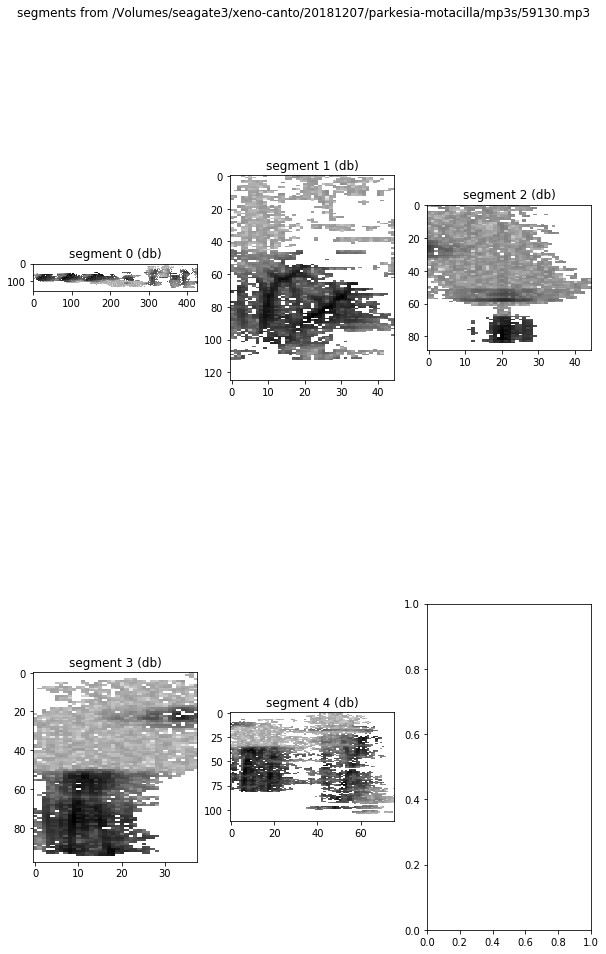

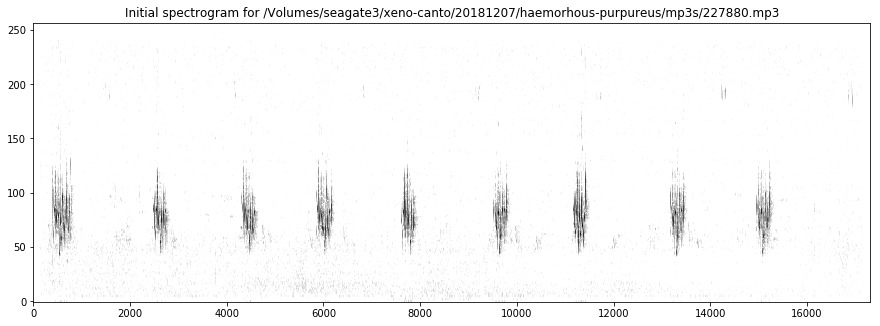

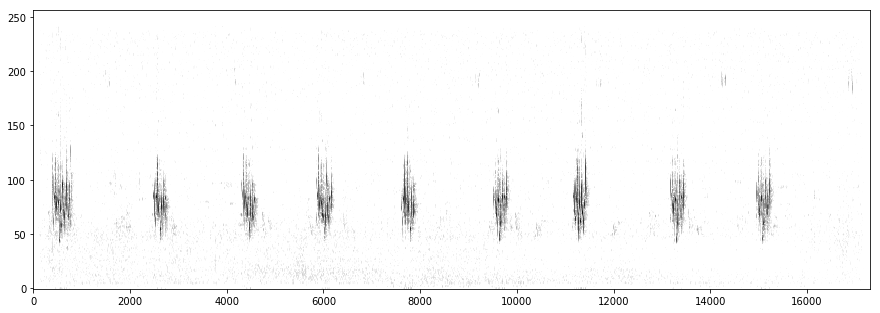

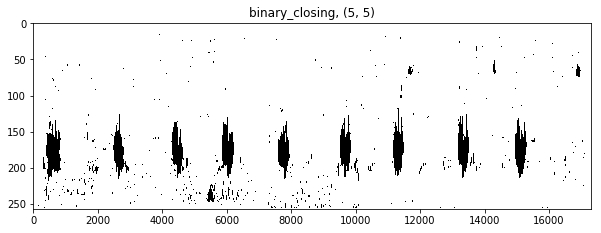

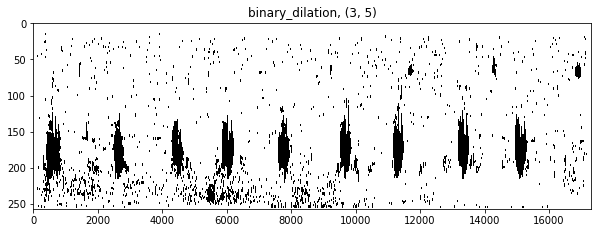

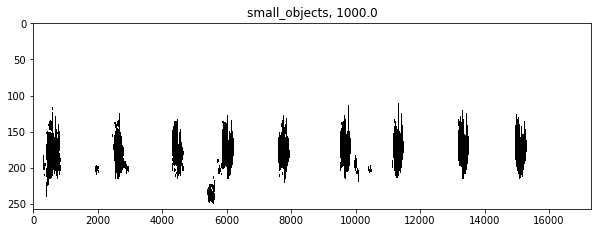

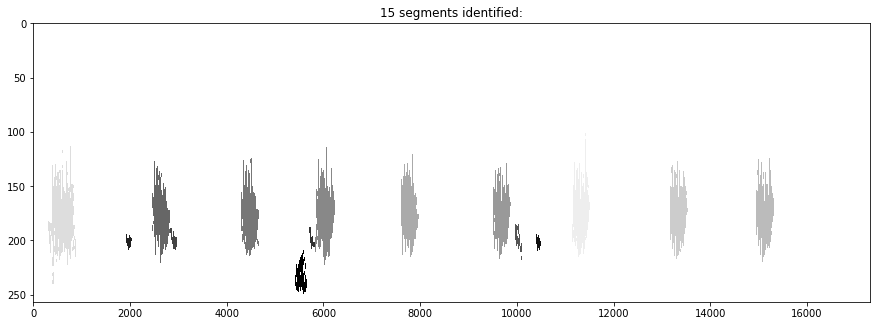

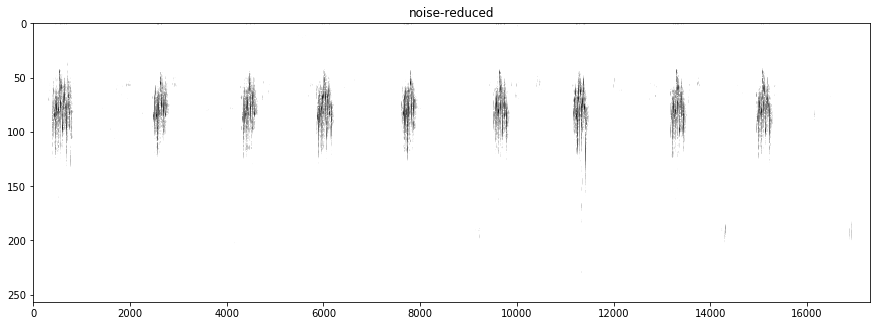

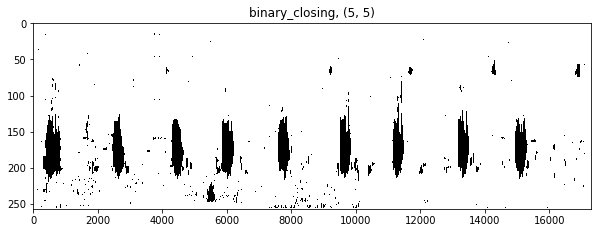

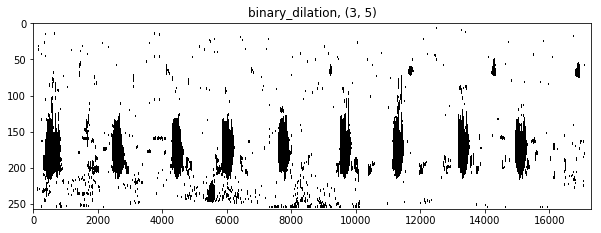

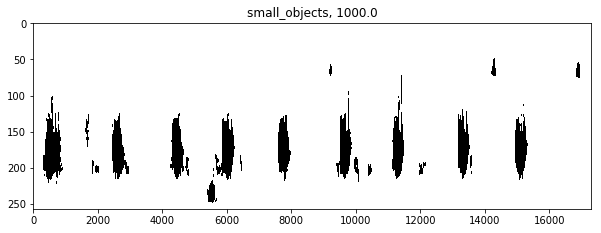

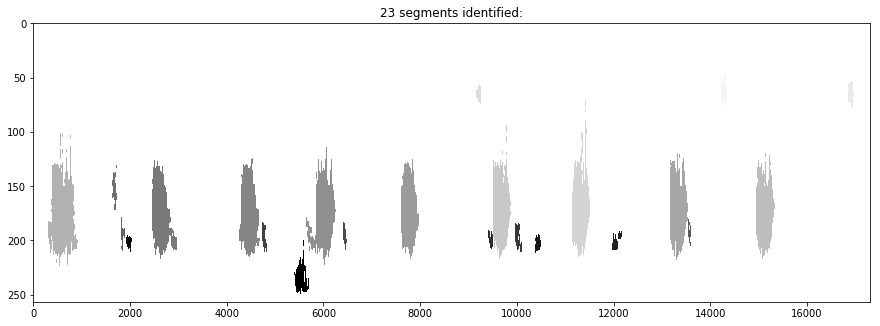

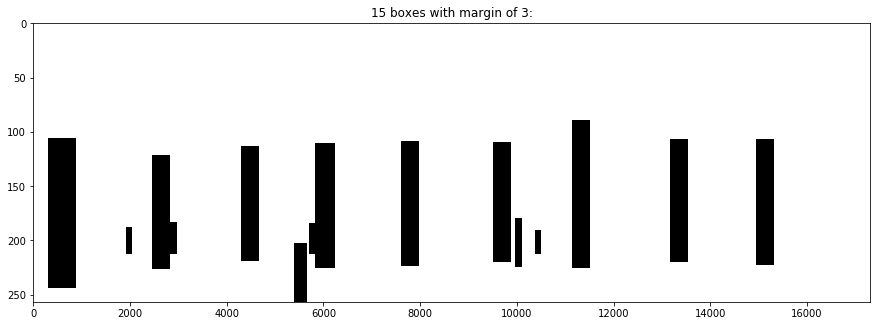

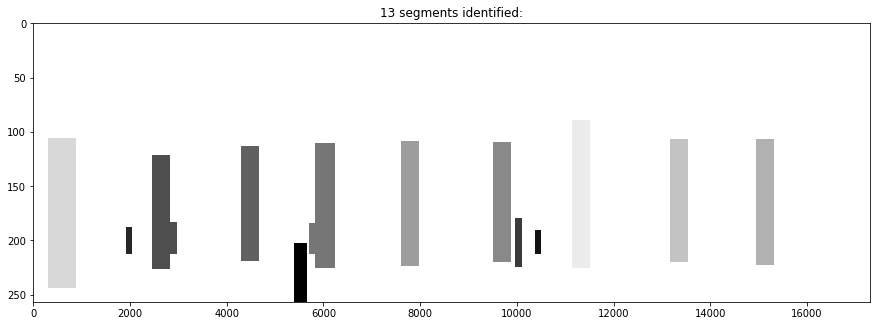

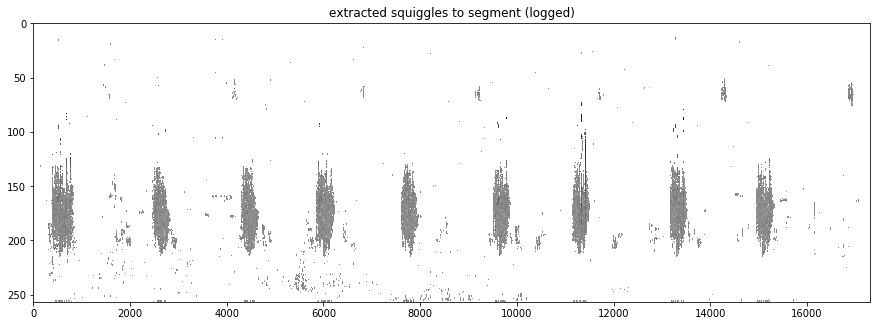

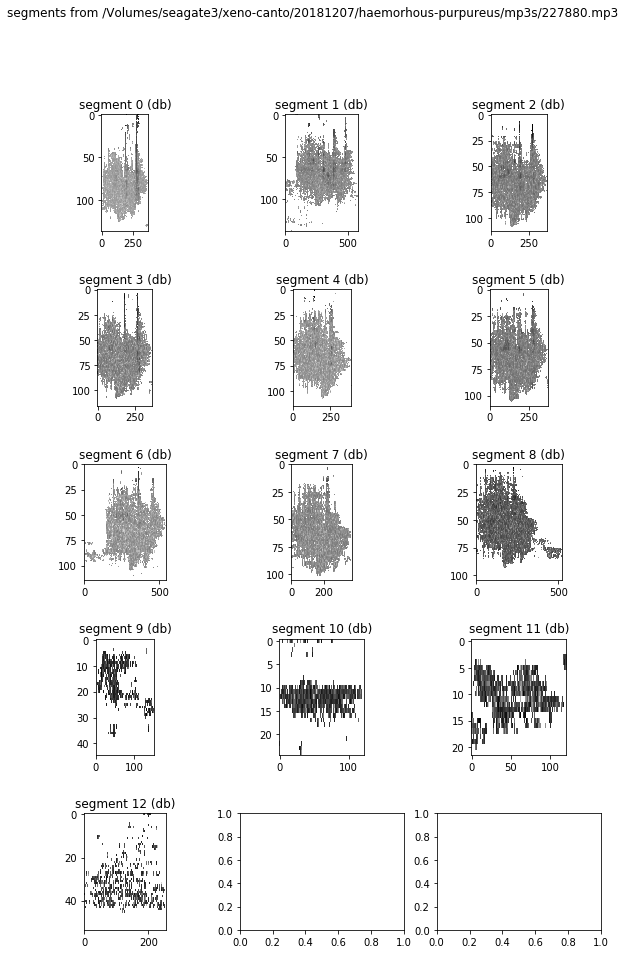

In [24]:
filenames = recordings_to_use
samples_per_seg = 512
overlap_percent = 0.75
sample_rate = 22050.0

segs_dict = {}

base_dir = '/Volumes/lacie/10birds-data'
try: os.mkdir(base_dir)
except FileExistsError:
    pass

debug=True

for filename in filenames:
    # Load file
    samples, sample_rate = load_file(
        filename = filename,
        sample_rate = sample_rate)
    
    # Place to store the results
    split = filename.split('/')
    species = split[5]
    cat_num = os.path.splitext(split[7])[0] #splitext removes the .mp3
    base_dir_1 = os.path.join(base_dir, species)
    try: os.mkdir(base_dir_1)
    except FileExistsError:
        pass
    newdir = os.path.join(base_dir_1, cat_num)

    # Make spectrogram
    freqs, times, spect = make_spect(
        samples = samples,
        samples_per_seg = samples_per_seg,
        overlap_percent = overlap_percent,
        sample_rate = sample_rate)
    plotter(spect, upside_down=True, title=f'Initial spectrogram for {filename}', db=True)

    # Remove undesired frequencies
    #low_frequency_thresh = 173
    #high_frequency_thresh = 10033
    #spect, f = spectrogram_bandpass(spect, f, low_frequency_thresh, high_frequency_thresh)
    if debug:
        plotter(power_to_db(spect), upside_down=True)

    ### STEP 1 ###
    # Normalize spectrogram
    normalized_spect = normalize_spect(spect)

    # Binarize by median filtering
    median_binarize_multiplier = 9.0
    binary_spect = binarize_by_median(normalized_spect, multiplier = median_binarize_multiplier)
    
    # Image processing noise reduction
    small_obj_size = 1000.0
    binary_closing_size = (5, 5)
    binary_dilation_size = (3, 5)
    desired_steps = OrderedDict({
        'binary_closing':binary_closing_size,
        'binary_dilation':binary_dilation_size,
        'small_objects':small_obj_size
    })
    if debug:
        binary_processed = image_processing_dict( 
            spectrogram = binary_spect,
            params = desired_steps,
            plot_func = plotter
        )
    else:
        binary_processed = image_processing_dict( 
            spectrogram = binary_spect,
            params = desired_steps
            #plot_func = plotter
        )

    # Find bounding boxes in processed spect
    bounding_boxes = box_binary(binary_processed)

    # Use bounding boxes to save a noise file
    noise_filename = save_noise_file(
        binary_spectrogram=binary_processed,
        bounding_boxes=bounding_boxes,
        original_filename=filename,
        samples = samples,
        freqs = freqs,
        times = times,
        sr = sample_rate,
        newdir = newdir,
        subdir = None
    )

    # Noise-reduce the samples
    samples_nr = audacity_noise_reduce(noise_file=noise_filename, audio_samples=samples)
    freqs_nr, times_nr, spect_nr = make_spect(samples_nr, samples_per_seg=samples_per_seg, overlap_percent=overlap_percent)
    if debug:
        plotter(spect_nr, db=True, title='noise-reduced')

    # Save denoised sound file
    wav_writer(samples = samples_nr, sample_rate=sample_rate, suffix='denoised', orig=filename, newdir=newdir)
    
    
    
    
    ## STEP 2 ##
    
    # Normalize spectrogram
    spect_normalized_nr = normalize_spect(spect_nr)

    # Binarize by median filtering
    median_binarize_multiplier = 9.0
    binary_spect_nr = binarize_by_median(spect_normalized_nr, multiplier = median_binarize_multiplier)
    
    # Image processing noise reduction
    small_obj_size = 1000.0
    binary_closing_size = (5, 5)
    binary_dilation_size = (3, 5)
    desired_steps = OrderedDict({
        'binary_closing':binary_closing_size,
        'binary_dilation':binary_dilation_size,
        'small_objects':small_obj_size
    })
    if debug:
        binary_processed_nr = image_processing_dict( 
            spectrogram = binary_spect_nr,
            params = desired_steps,
            plot_func = plotter
        )
    else:
        binary_processed_nr = image_processing_dict( 
            spectrogram = binary_spect_nr,
            params = desired_steps
            #plot_func = plotter
        )

    # Find bounding boxes in processed spect
    bounding_boxes_nr = box_binary(binary_processed_nr)

    
    ### STEP 3 ##
    
    
    # If using Audacity noise reduction and binary_spect was not made from 
    # the noise-reduced spectrogram, it will be slightly larger than the 
    # noise-reduced spect. Make them the same size by just selecting the 
    # first part of the binary_spect:
    if spect_nr.shape != binary_spect_nr.shape:
        shape_difference = np.subtract(spect_nr.shape, binary_spect.shape)
        new_dims = np.add(binary_spect.shape, shape_difference)
        # TODO: centering this might work better than just taking the beginning
        binary_spect_to_use = binary_spect_nr[0:new_dims[0], 0:new_dims[1]]
    else:
        binary_spect_to_use = binary_spect_nr
    
    # Identify segments
    segs = identify_segments(spect_nr, binary_spect_to_use, bounding_boxes, plot_func=plotter, margin = 3)#, method='min')
    
    # Save samples
    for idx, box in enumerate(bounding_boxes):
        # convert box, which is in terms of numpy array, to sample number and frequency number
        high_freq, low_freq, start_sample, end_sample = box_to_ft(box, freqs_nr, times, sample_rate) #Note: times_nr results in out of bounds

        # extract those samples from the audio
        segment_samples = samples_nr[start_sample: end_sample]

        # bandpass filter the samples above and below the box limits
        filtered_samples = butter_bandpass_filter(segment_samples, low_freq, high_freq, sample_rate)

        # save samples
        wav_writer(filtered_samples, sample_rate, f'detection{idx}', orig=filename, newdir=newdir, subdir='detections')
    
    
    # save for later so that we could plot them in different ways if desired
    segs_dict[filename] = segs
    
    num_segs = len(segs)
    num_cols = 3
    num_rows = int(np.ceil(num_segs/num_cols))
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 15))
    ordered_axes = []
    if num_rows == 1:
        for ax1 in range(ax.shape[0]):
            ordered_axes.append(ax[ax1])
    else:
        for ax1 in range(ax.shape[0]):
            for ax2 in range(ax.shape[1]):
                ordered_axes.append(ax[ax1][ax2])
    for idx, axis in enumerate(ordered_axes):
        if idx >= len(segs):
            break
        axis.imshow(np.log(cropper(segs[idx])), cmap=plt.get_cmap("gray_r"))
        axis.set_title(f'segment {idx} (db)')
        axis.set_aspect(segs[idx].shape[1] / (10*segs[idx].shape[0]))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f'segments from {filename}')

# Method with one round of detection

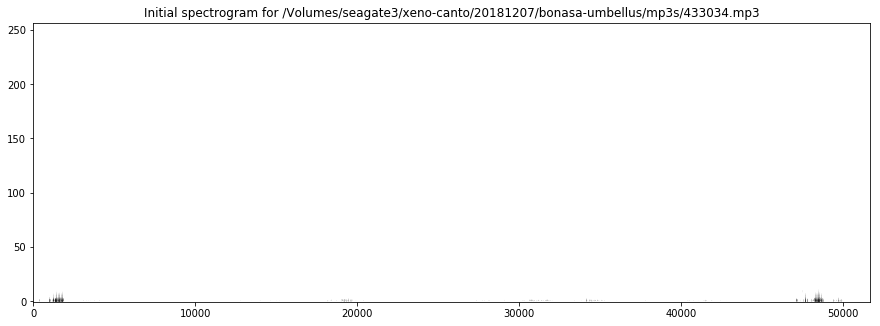

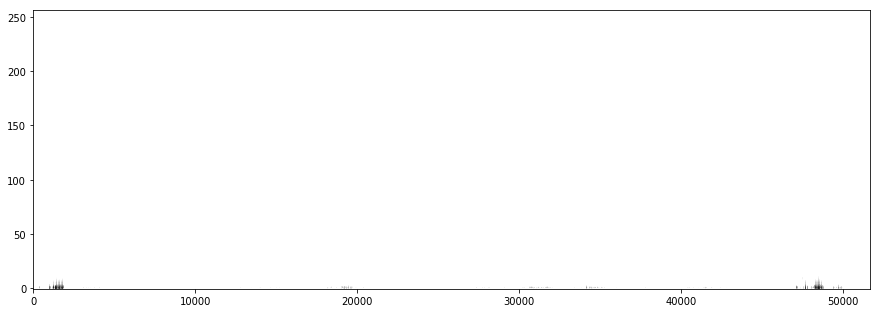

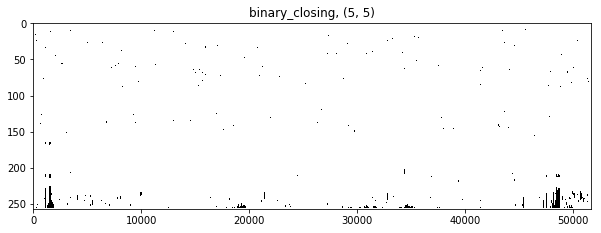

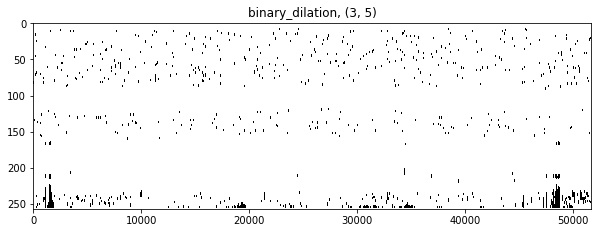

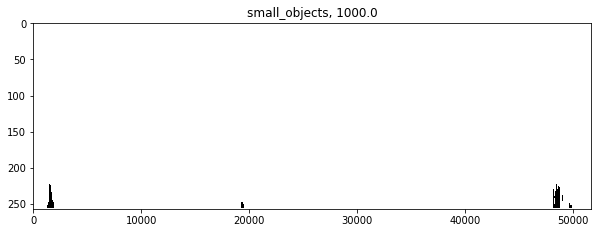

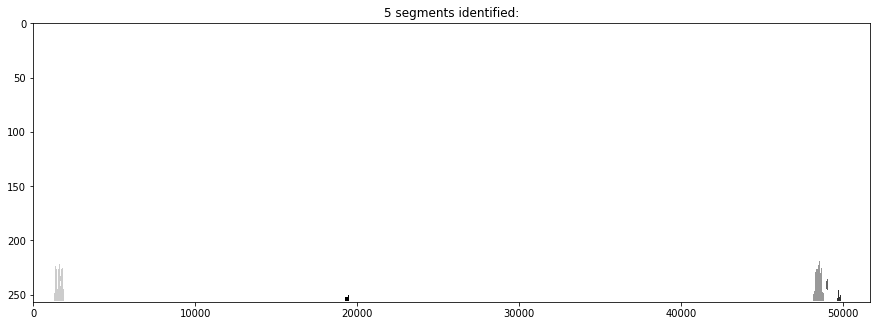

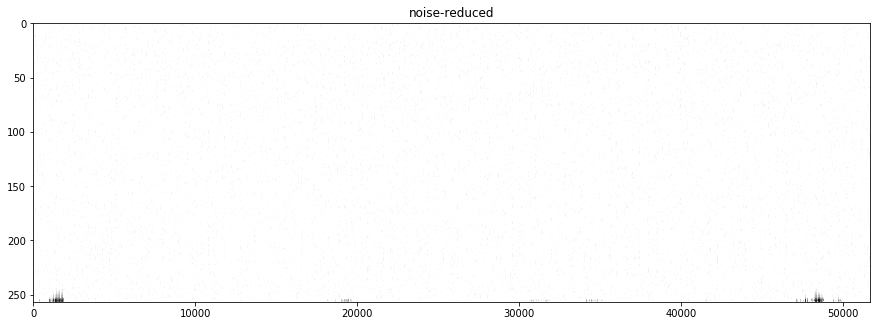

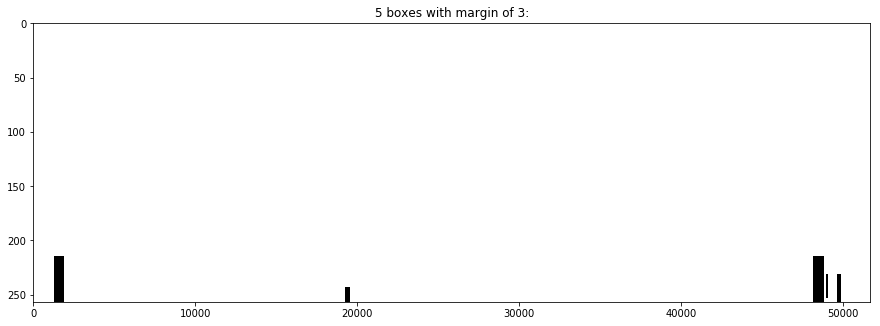

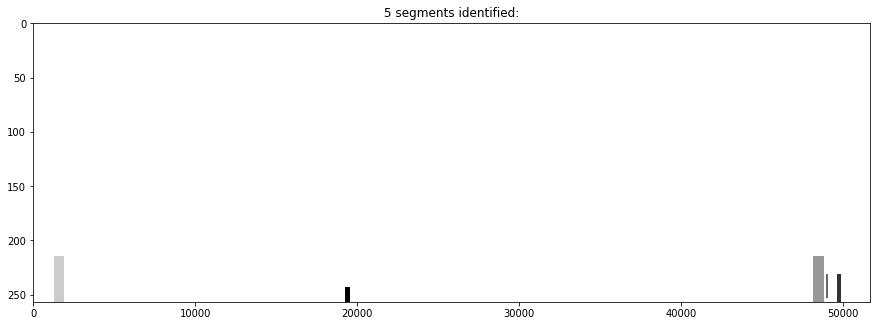

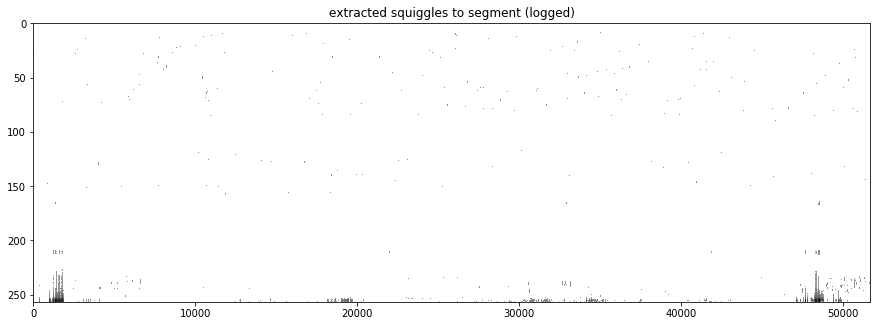

/Users/ter38/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


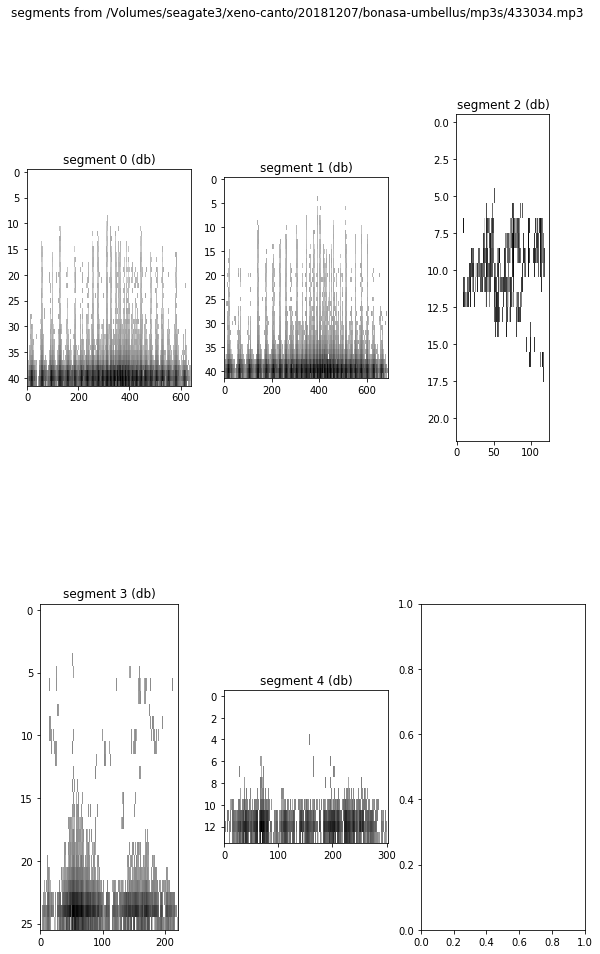

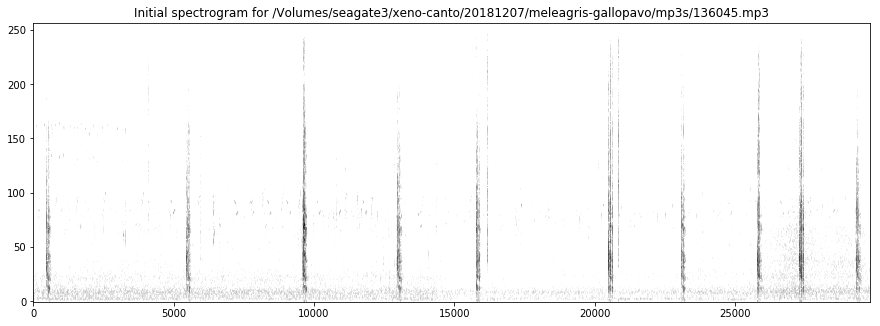

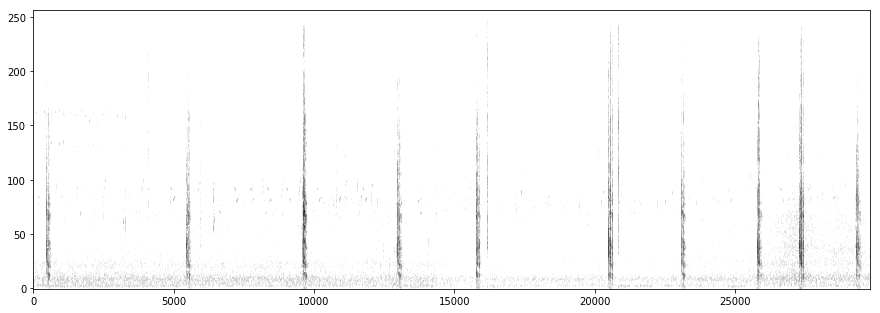

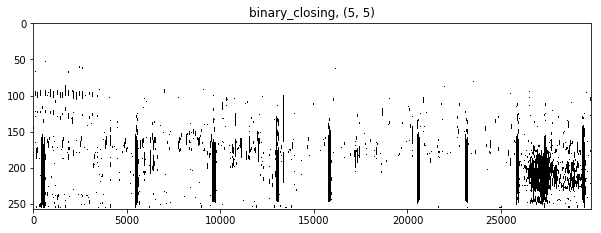

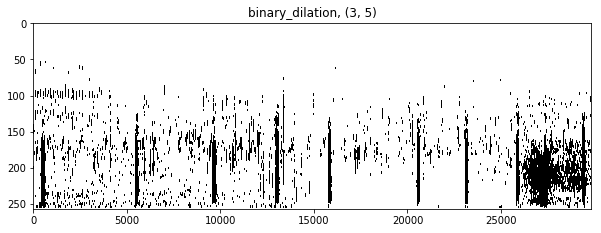

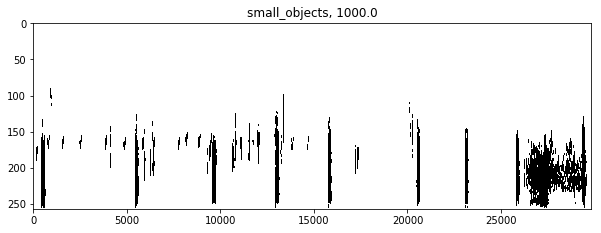

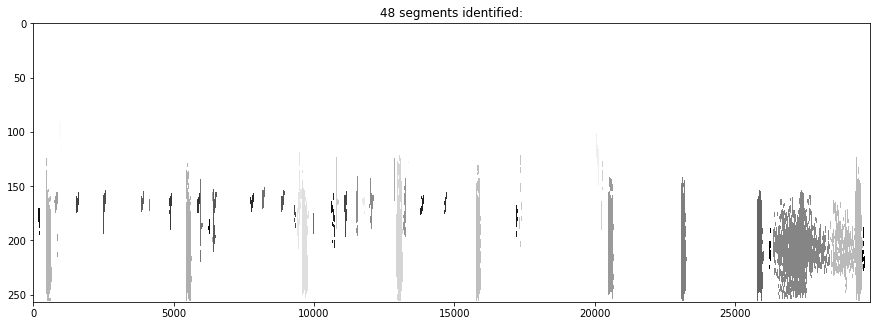

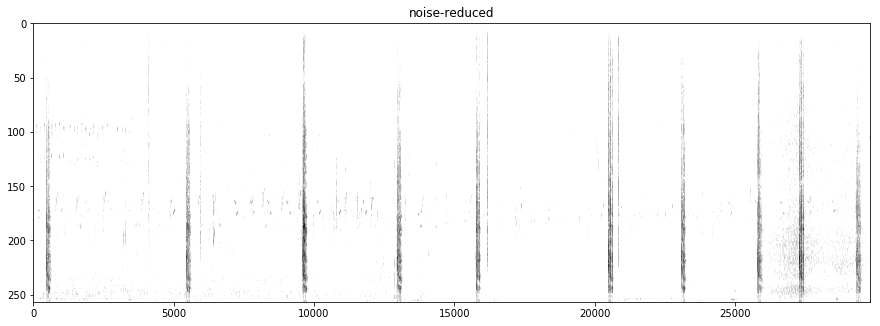

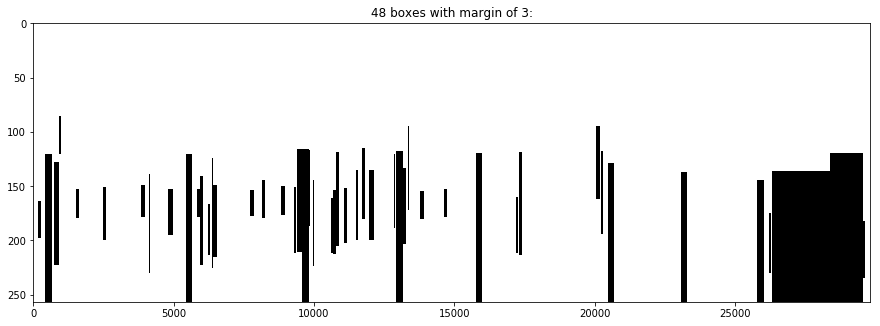

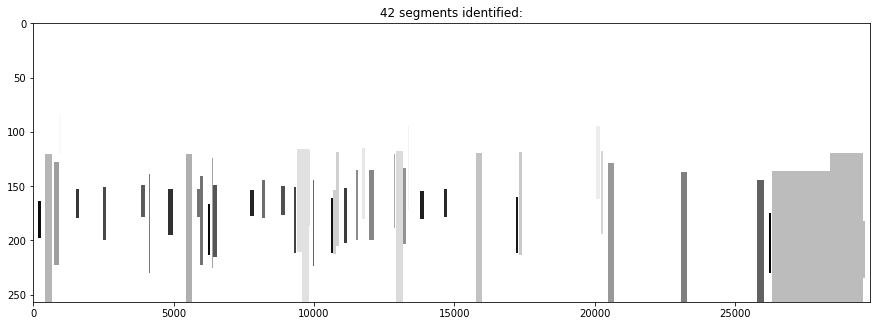

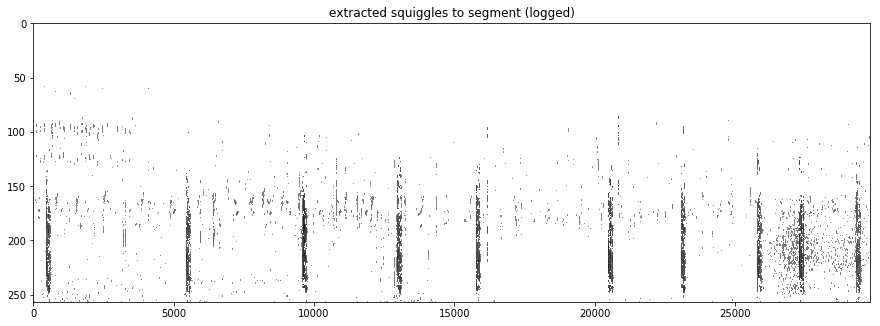

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: divide by zero encountered in log


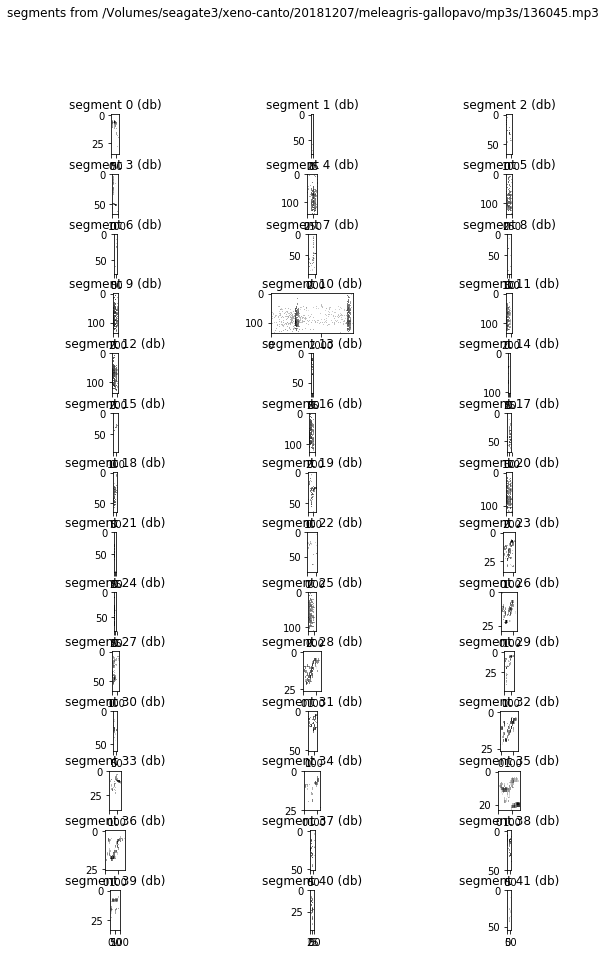

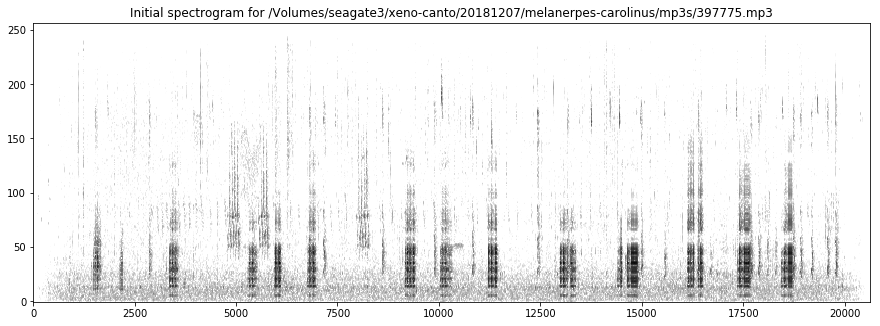

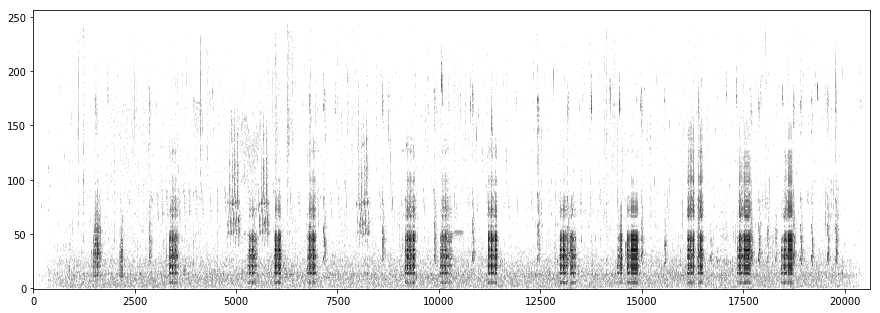

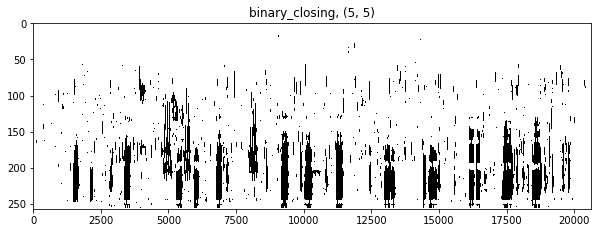

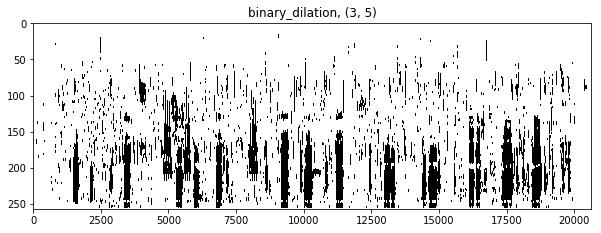

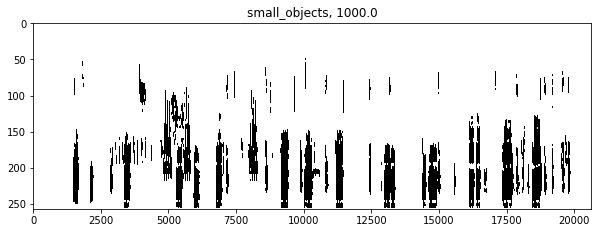

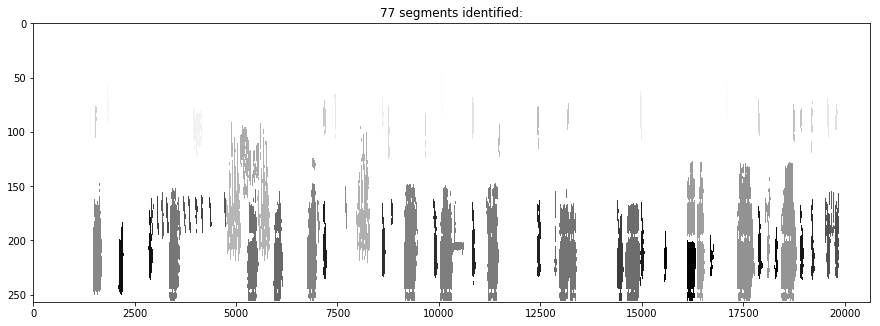

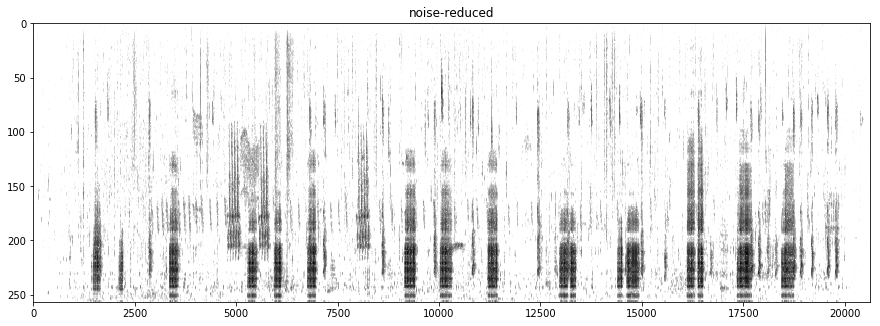

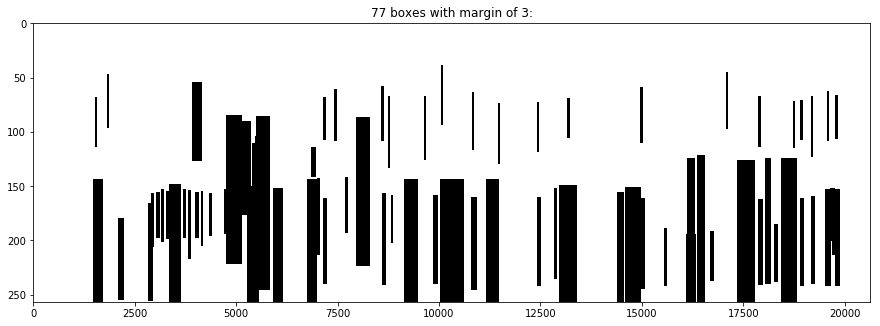

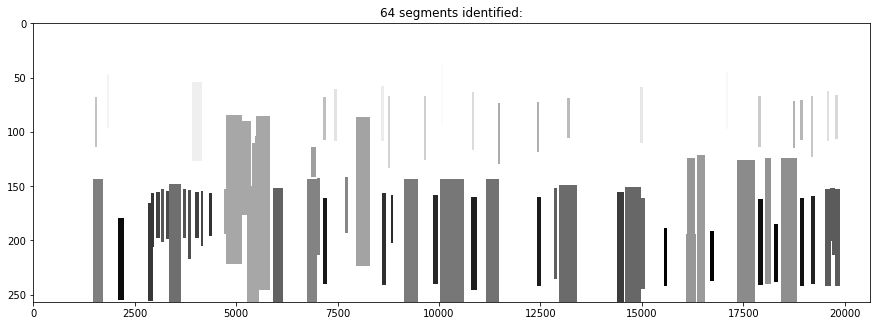

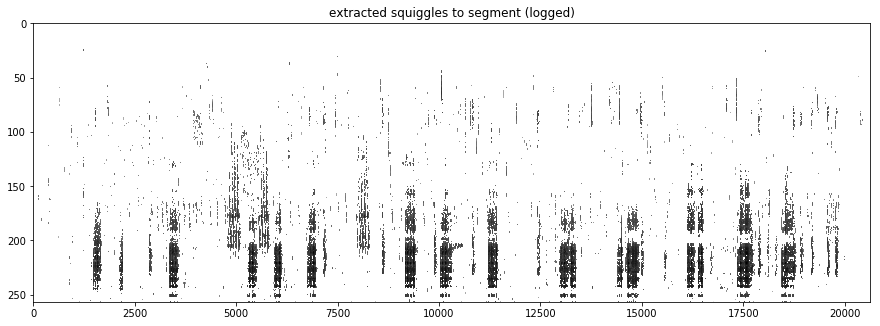

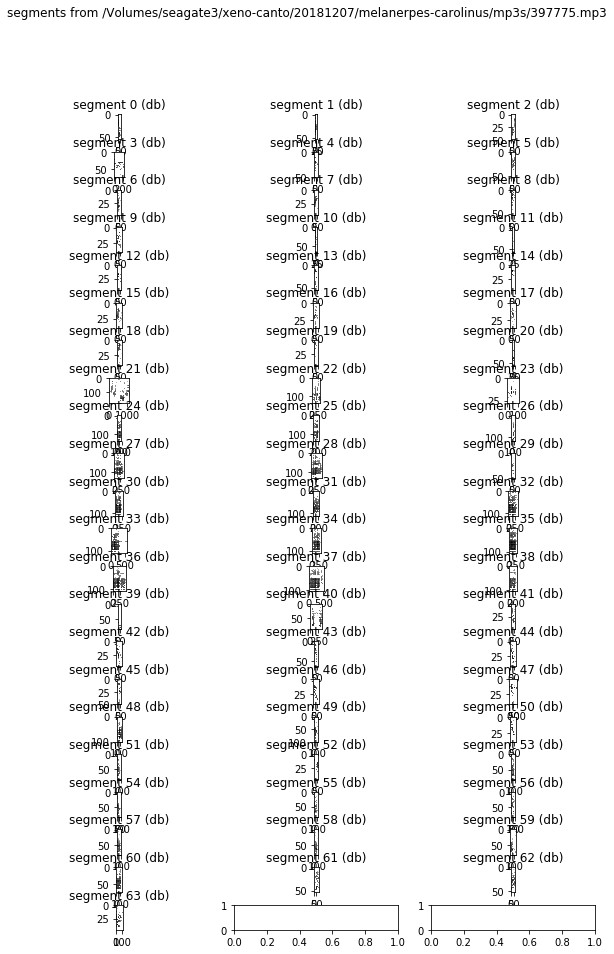

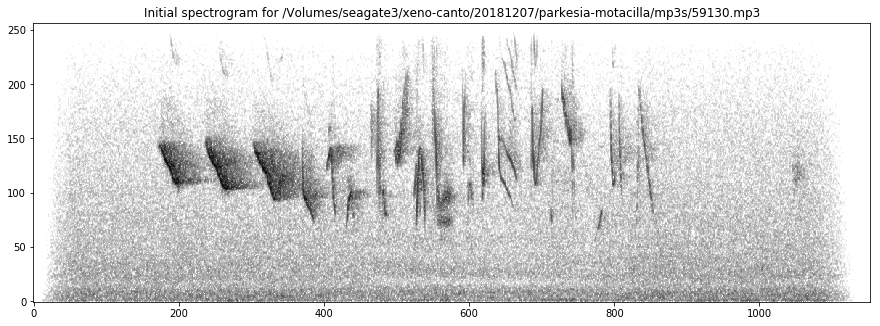

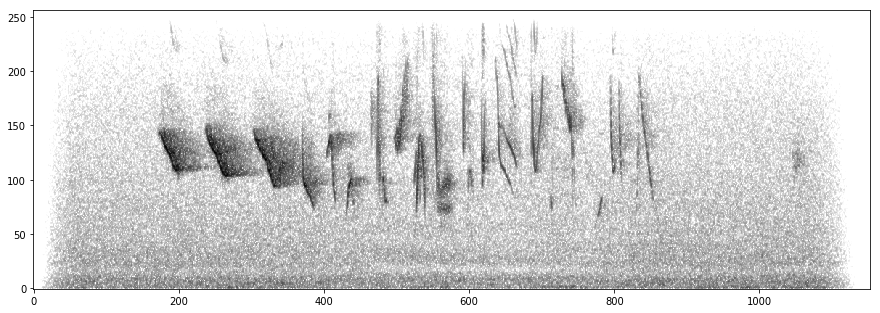

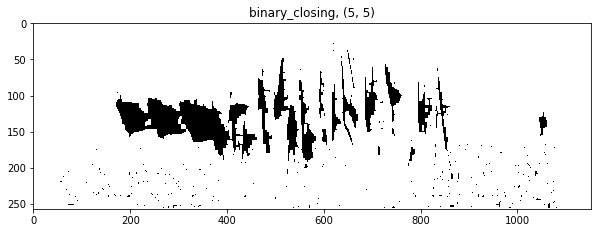

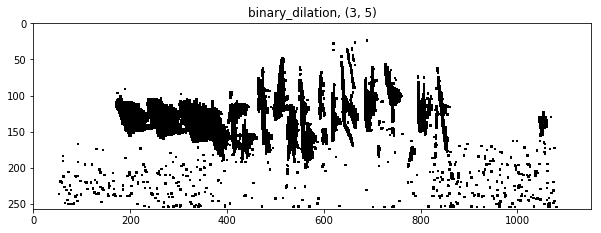

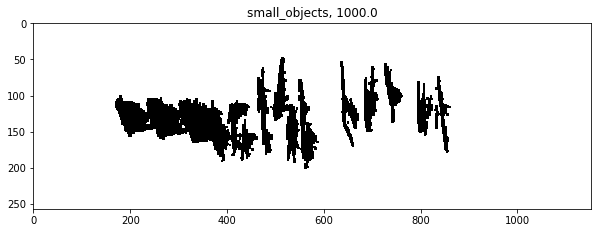

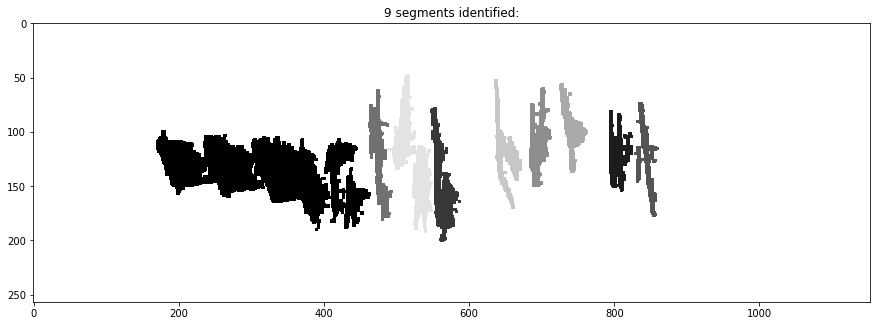

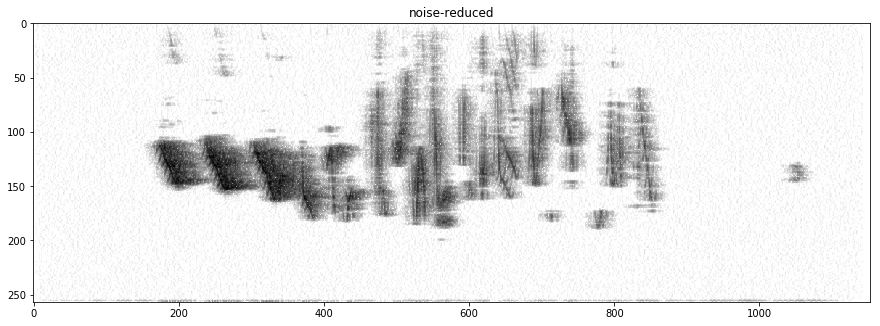

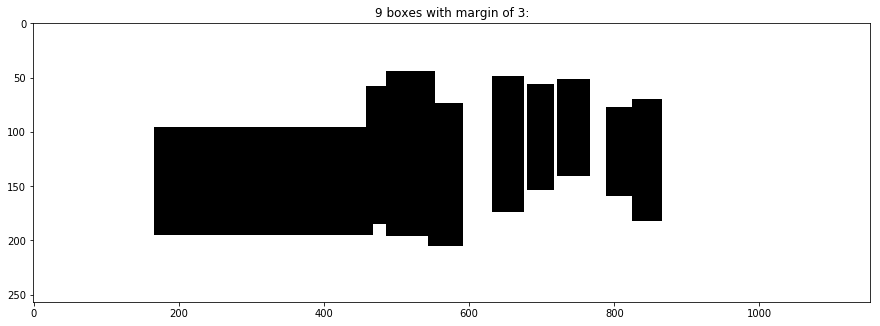

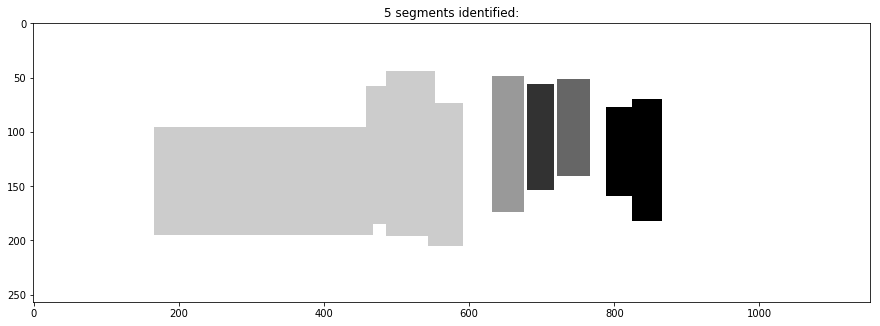

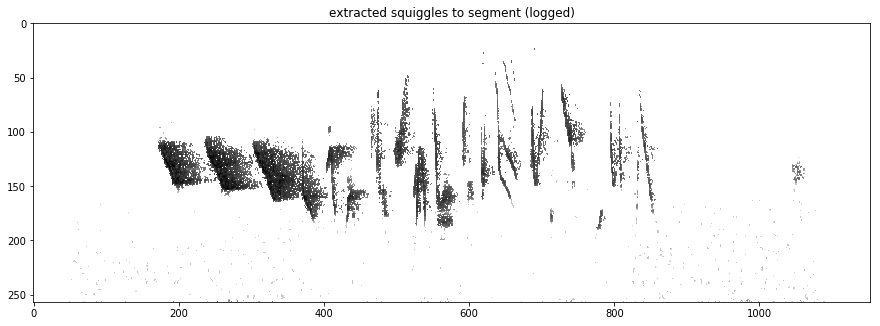

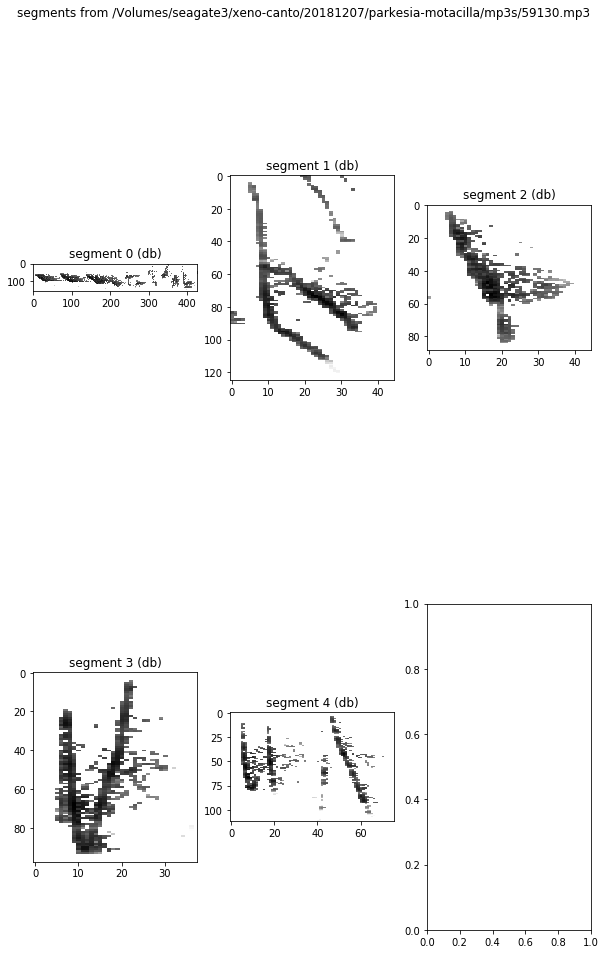

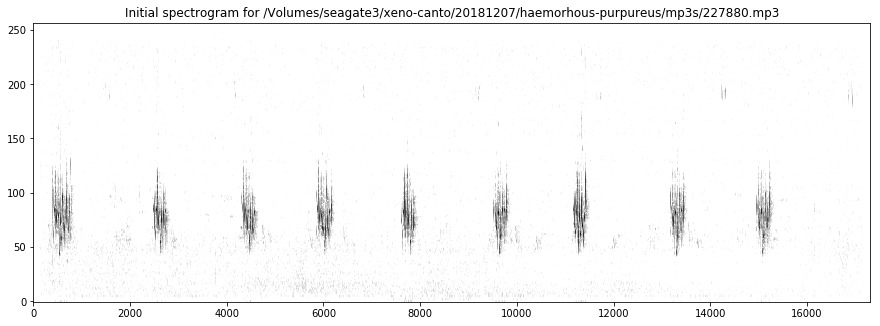

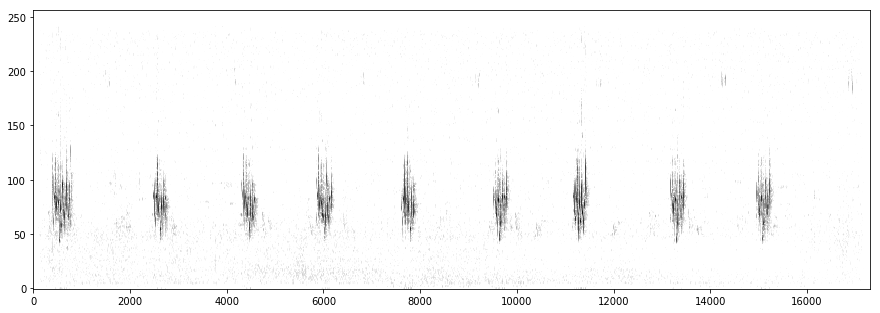

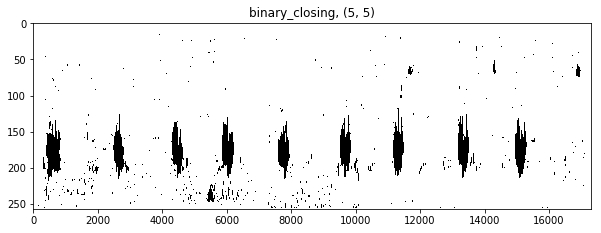

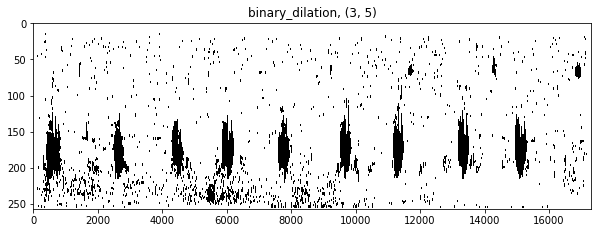

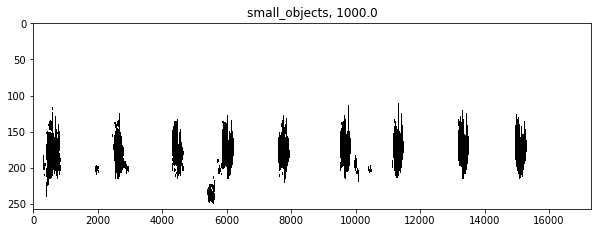

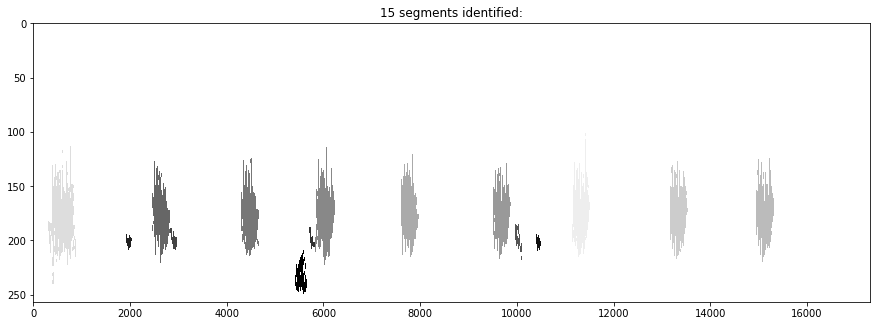

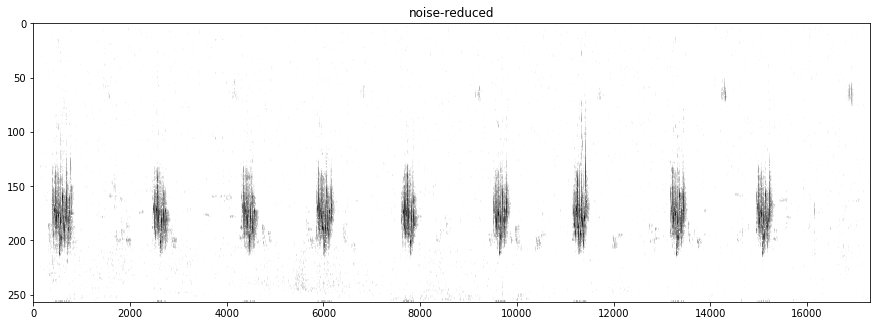

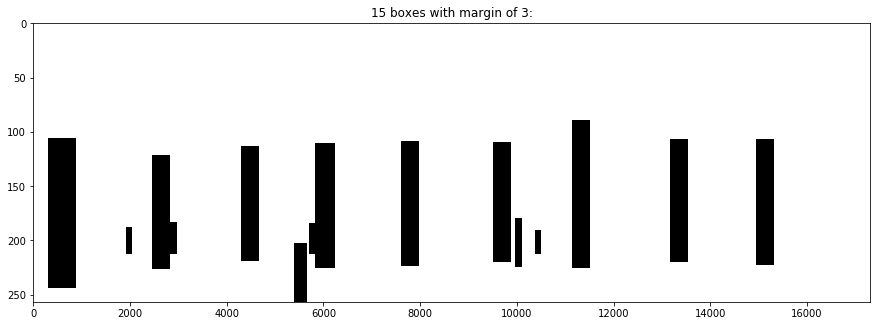

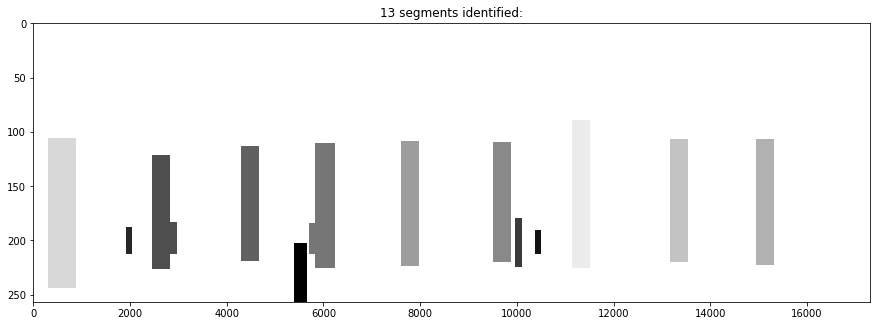

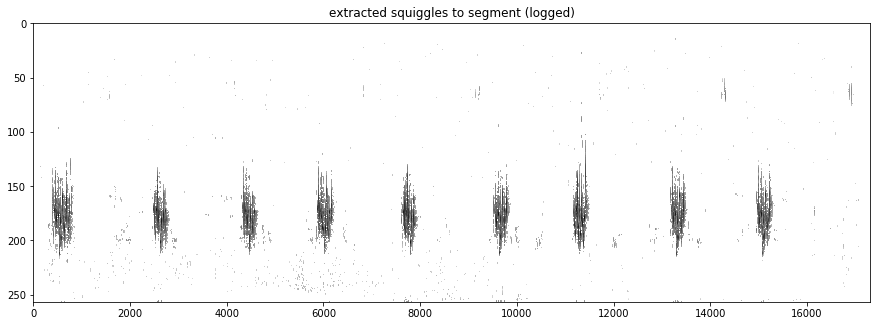

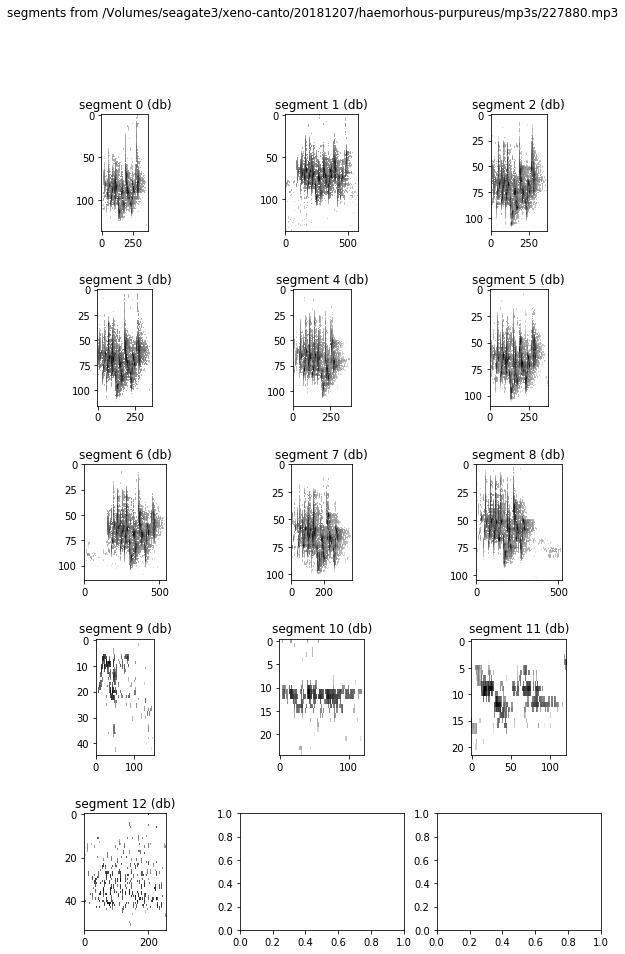

In [23]:
filenames = recordings_to_use
samples_per_seg = 512
overlap_percent = 0.75
sample_rate = 22050.0

segs_dict = {}

base_dir = '/Volumes/lacie/10birds-data'
try: os.mkdir(base_dir)
except FileExistsError:
    pass

debug=True

for filename in filenames:
    # Load file
    samples, sample_rate = load_file(
        filename = filename,
        sample_rate = sample_rate)
    
    # Place to store the results
    split = filename.split('/')
    species = split[5]
    cat_num = os.path.splitext(split[7])[0] #splitext removes the .mp3
    base_dir_1 = os.path.join(base_dir, species)
    try: os.mkdir(base_dir_1)
    except FileExistsError:
        pass
    newdir = os.path.join(base_dir_1, cat_num)

    # Make spectrogram
    freqs, times, spect = make_spect(
        samples = samples,
        samples_per_seg = samples_per_seg,
        overlap_percent = overlap_percent,
        sample_rate = sample_rate)
    plotter(spect, upside_down=True, title=f'Initial spectrogram for {filename}', db=True)

    # Remove undesired frequencies
    #low_frequency_thresh = 173
    #high_frequency_thresh = 10033
    #spect, f = spectrogram_bandpass(spect, f, low_frequency_thresh, high_frequency_thresh)
    if debug:
        plotter(power_to_db(spect), upside_down=True)

    ### STEP 1 ###
    # Normalize spectrogram
    normalized_spect = normalize_spect(spect)

    # Binarize by median filtering
    median_binarize_multiplier = 9.0
    binary_spect = binarize_by_median(normalized_spect, multiplier = median_binarize_multiplier)
    
    # Image processing noise reduction
    small_obj_size = 1000.0
    binary_closing_size = (5, 5)
    binary_dilation_size = (3, 5)
    desired_steps = OrderedDict({
        'binary_closing':binary_closing_size,
        'binary_dilation':binary_dilation_size,
        'small_objects':small_obj_size
    })
    if debug:
        binary_processed = image_processing_dict( 
            spectrogram = binary_spect,
            params = desired_steps,
            plot_func = plotter
        )
    else:
        binary_processed = image_processing_dict( 
            spectrogram = binary_spect,
            params = desired_steps
            #plot_func = plotter
        )

    # Find bounding boxes in processed spect
    bounding_boxes = box_binary(binary_processed)

    # Use bounding boxes to save a noise file
    noise_filename = save_noise_file(
        binary_spectrogram=binary_processed,
        bounding_boxes=bounding_boxes,
        original_filename=filename,
        samples = samples,
        freqs = freqs,
        times = times,
        sr = sample_rate,
        newdir = newdir,
        subdir = None
    )

    # Noise-reduce the samples
    samples_nr = audacity_noise_reduce(noise_file=noise_filename, audio_samples=samples)
    freqs_nr, times_nr, spect_nr = make_spect(samples_nr, samples_per_seg=samples_per_seg, overlap_percent=overlap_percent)
    spect_nr = normalize_spect(spect_nr)
    if debug:
        plotter(spect_nr, db=True, title='noise-reduced')

    # Save denoised sound file
    wav_writer(samples = samples_nr, sample_rate=sample_rate, suffix='denoised', orig=filename, newdir=newdir)
    
    ## STEP 2 ##
    
    
    # If using Audacity noise reduction and binary_spect was not made from 
    # the noise-reduced spectrogram, it will be slightly larger than the 
    # noise-reduced spect. Make them the same size by just selecting the 
    # first part of the binary_spect:
    if spect_nr.shape != binary_spect.shape:
        shape_difference = np.subtract(spect_nr.shape, binary_spect.shape)
        new_dims = np.add(binary_spect.shape, shape_difference)
        # TODO: centering this might work better than just taking the beginning
        binary_spect_to_use = binary_spect[0:new_dims[0], 0:new_dims[1]]
    else:
        binary_spect_to_use = binary_spect
    
    # Identify segments
    segs = identify_segments(spect_nr, binary_spect_to_use, bounding_boxes, plot_func=plotter, margin = 3)#, method='min')
    
    # Save samples
    for idx, box in enumerate(bounding_boxes):
        # convert box, which is in terms of numpy array, to sample number and frequency number
        high_freq, low_freq, start_sample, end_sample = box_to_ft(box, freqs_nr, times, sample_rate) #Note: times_nr results in out of bounds

        # extract those samples from the audio
        segment_samples = samples_nr[start_sample: end_sample]

        # bandpass filter the samples above and below the box limits
        filtered_samples = butter_bandpass_filter(segment_samples, low_freq, high_freq, sample_rate)

        # save samples
        wav_writer(filtered_samples, sample_rate, f'detection{idx}', orig=filename, newdir=newdir, subdir='detections')
    
    
    # save for later so that we could plot them in different ways if desired
    segs_dict[filename] = segs
    
    num_segs = len(segs)
    num_cols = 3
    num_rows = int(np.ceil(num_segs/num_cols))
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 15))
    ordered_axes = []
    if num_rows == 1:
        for ax1 in range(ax.shape[0]):
            ordered_axes.append(ax[ax1])
    else:
        for ax1 in range(ax.shape[0]):
            for ax2 in range(ax.shape[1]):
                ordered_axes.append(ax[ax1][ax2])
    for idx, axis in enumerate(ordered_axes):
        if idx >= len(segs):
            break
        axis.imshow(np.log(cropper(segs[idx])), cmap=plt.get_cmap("gray_r"))
        axis.set_title(f'segment {idx} (db)')
        axis.set_aspect(segs[idx].shape[1] / (10*segs[idx].shape[0]))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f'segments from {filename}')

# Example modified plotting



    for key in segs_dict.keys():
        segs = segs_dict[key]
        num_segs = len(segs)
        num_cols = 3
        num_rows = int(np.ceil(num_segs/num_cols))

        fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 15))
        ordered_axes = []
        for ax1 in range(ax.shape[0]):
            for ax2 in range(ax.shape[1]):
                ordered_axes.append(ax[ax1][ax2])
        for idx, axis in enumerate(ordered_axes):
            if idx >= len(segs):
                break
            axis.imshow(np.log(cropper(segs[idx])), cmap=plt.get_cmap("gray_r"))
            axis.set_title(f'segment {idx} (db)')
            axis.set_aspect(segs[idx].shape[1] / (10*segs[idx].shape[0]))
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle(f'segments from {key}')